# Figure planner

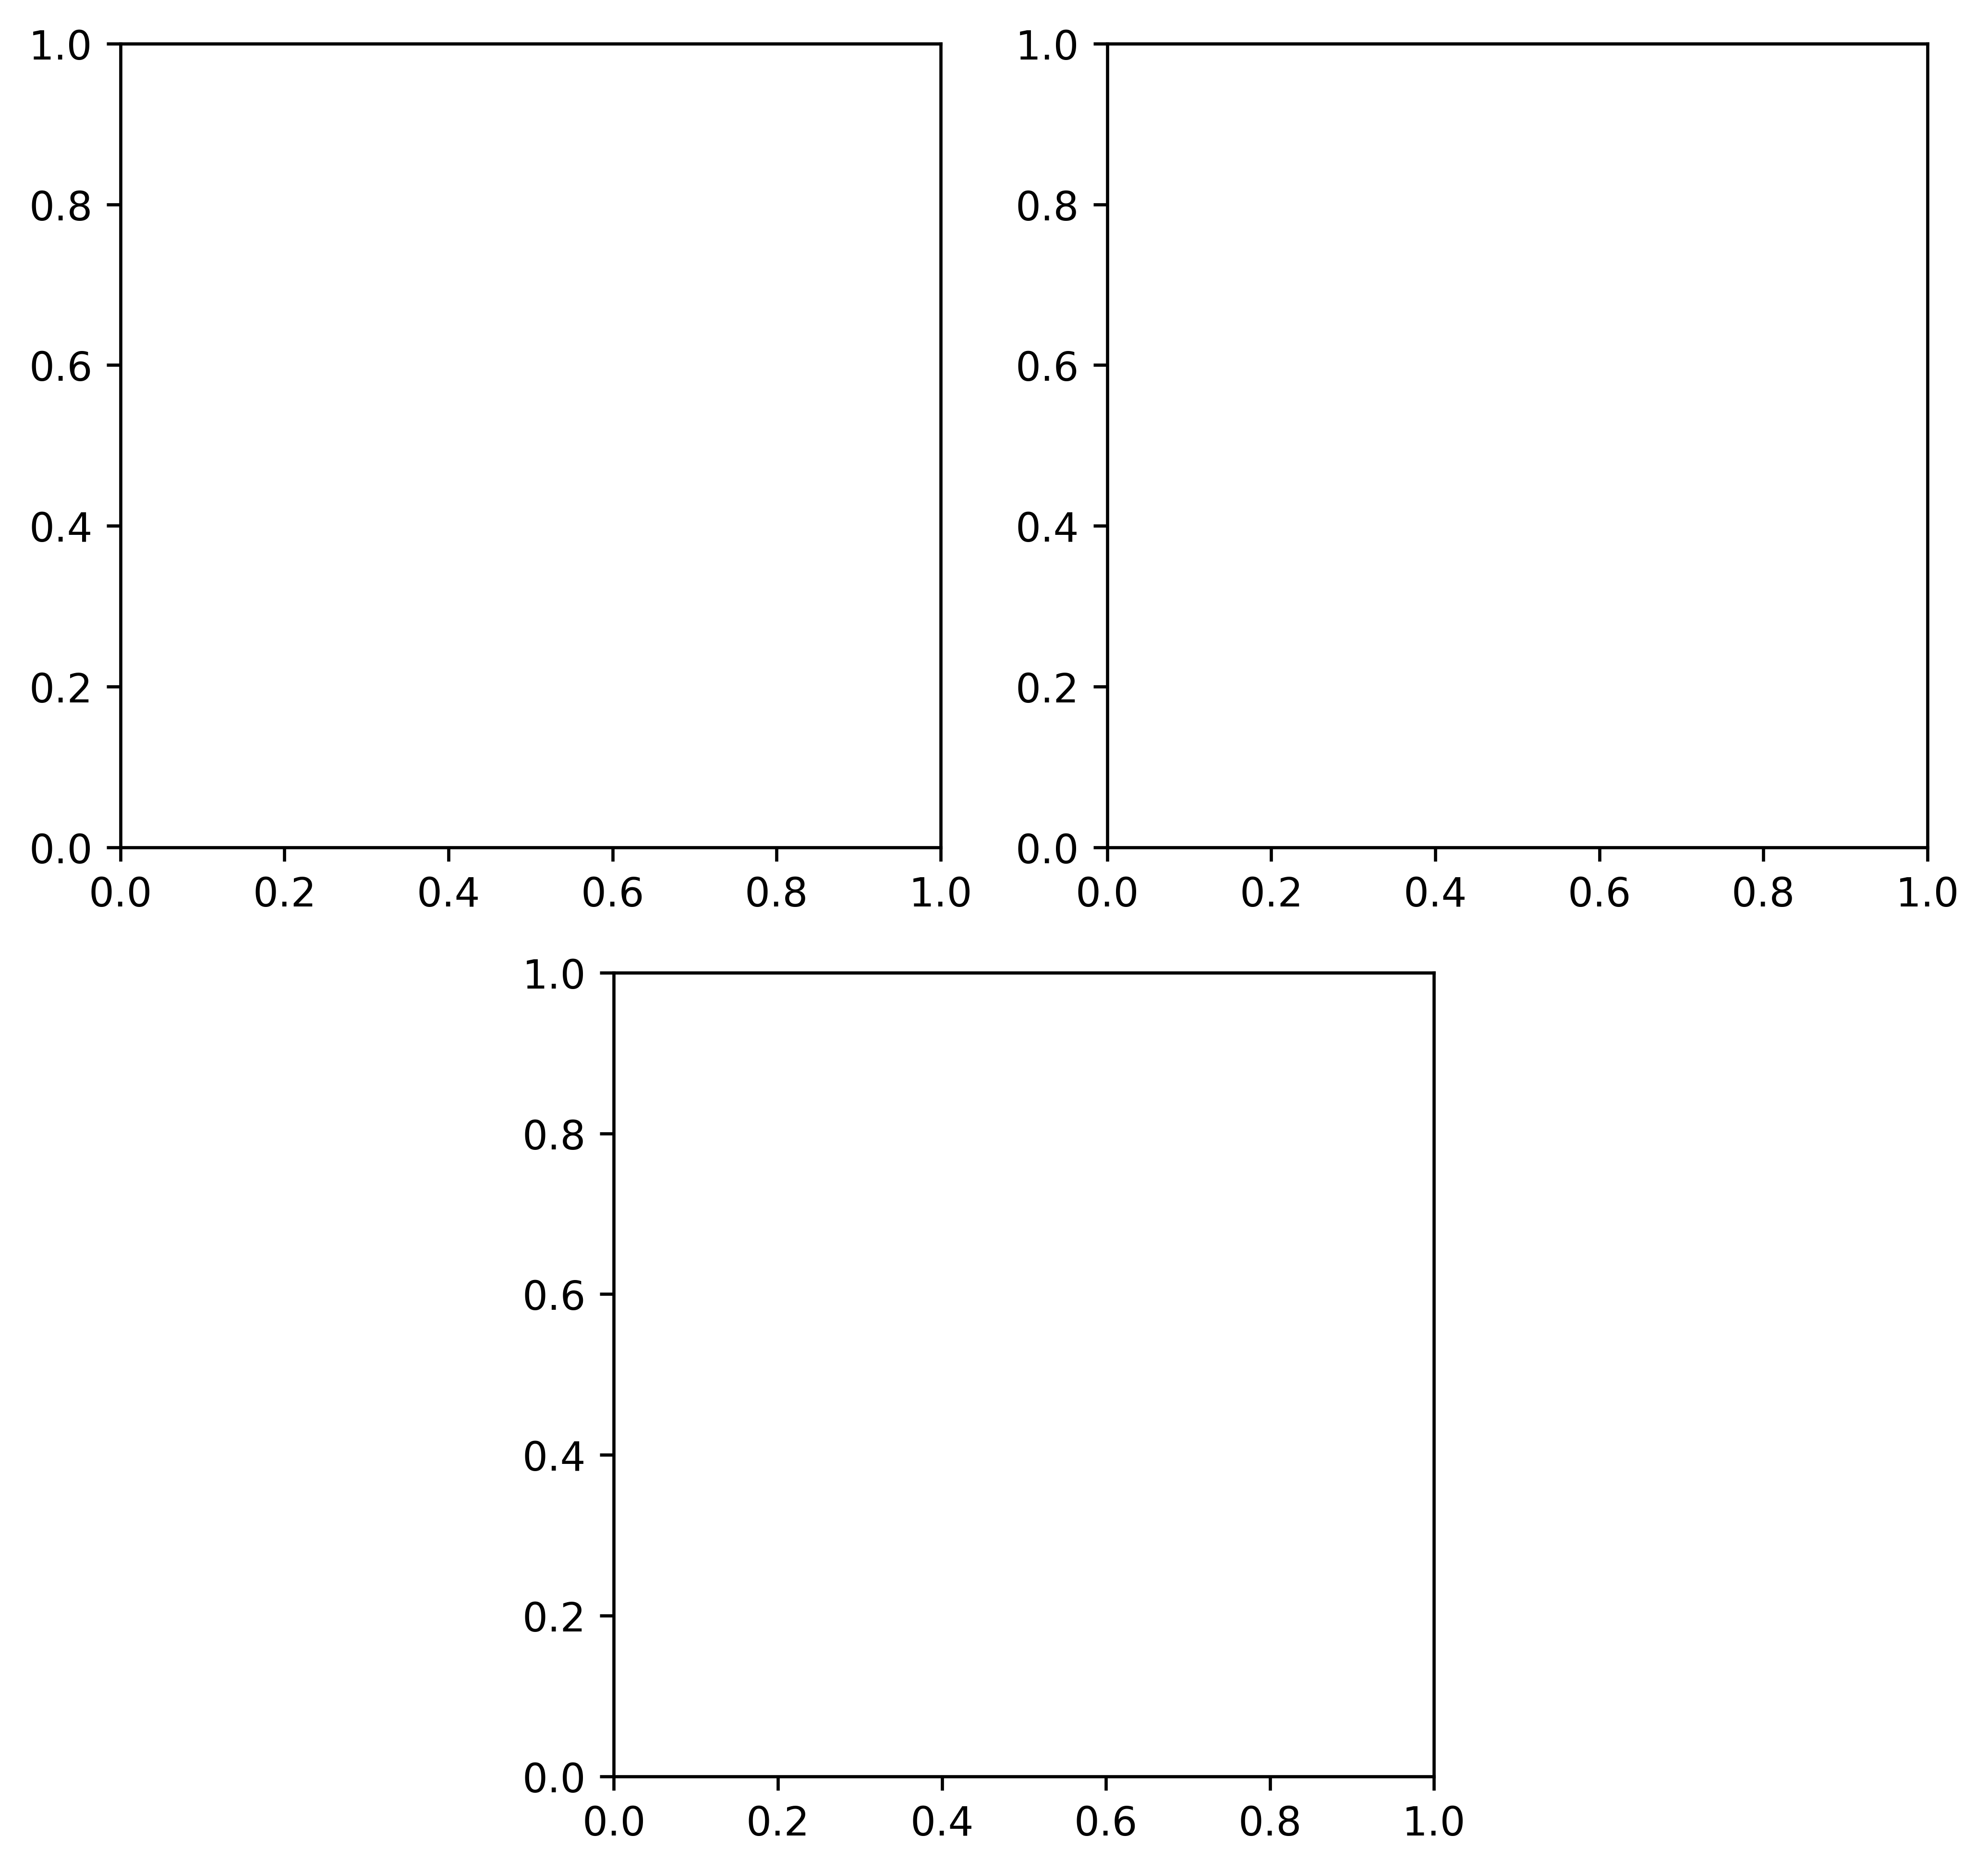

In [51]:
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

fig1 = plt.figure(figsize=(7, 6.6), dpi=600)

gs1 = GridSpec(2, 4, fig1)

ax00 = fig1.add_subplot(gs1[0, :2])
ax01 = fig1.add_subplot(gs1[0, 2:])
ax1 = fig1.add_subplot(gs1[1, 1:3])


# ax00.set_aspect("equal")
# ax01.set_aspect("equal")
# ax002.set_aspect("equal")

fig1.tight_layout()

# Fig. S1

In [1]:
import pandas as pd
from common import *

prom_raw = readModbam2bed("/mnt/data1/doh28/data/prom_R10.4.1_E8.2_WGS_brain_DH/dorado_0.3.2_basecalls/cbm1_prom_modbases_mapq60.bed", 1)

In [2]:
oxbs_raw = readBismarkZeroCov("/mnt/data1/doh28/data/CRR008808_oxBS/extraction_output/mapq_filter/CRR008808_oxBS_merged.bedGraph.gz.bismark.zero.cov", "5mC", 1)
tab_raw = readBismarkZeroCov("/mnt/data1/doh28/data/CRR008807_TAB/mapq_filtered/modified_bases/CRR008807_TAB_merged_resorted_q10.bedGraph.gz.bismark.zero.cov", "5hmC", 1)

In [3]:
all_raw = pd.merge(tab_raw, oxbs_raw, "inner", ["chromosome", "chromStart", "chromEnd"], suffixes=["_TAB", "_oxBS"]).merge(
    prom_raw, "inner", ["chromosome", "chromStart", "chromEnd"], suffixes=["_Bisulphite", "_Prom"])

In [4]:
readcounts_only = all_raw.drop(columns=["percentMeth_5hmC_Bisulphite", "percentMeth_5mC_Bisulphite", "strand", "percentMeth_C", "percentMeth_5mC_Prom", "percentMeth_5hmC_Prom"]).rename(columns={
    "readCount" : "readCount_Nanopore"
})

In [5]:
from pyranges import PyRanges
import CpGGrouping

readcount_features = PyRanges(changeColNamesForPR(readcounts_only)).join(CpGGrouping.featureRefPyRange(), strandedness=False, slack=0)

In [6]:
readcount_features_df = readcount_features.as_df().melt(id_vars=["Chromosome", "Start", "End", "feature_type"], 
                                                        value_vars=["readCount_TAB", "readCount_Nanopore", "readCount_oxBS"], 
                                                        value_name="readCount",
                                                        var_name="Method")

<Axes: xlabel='feature_type', ylabel='readCount'>

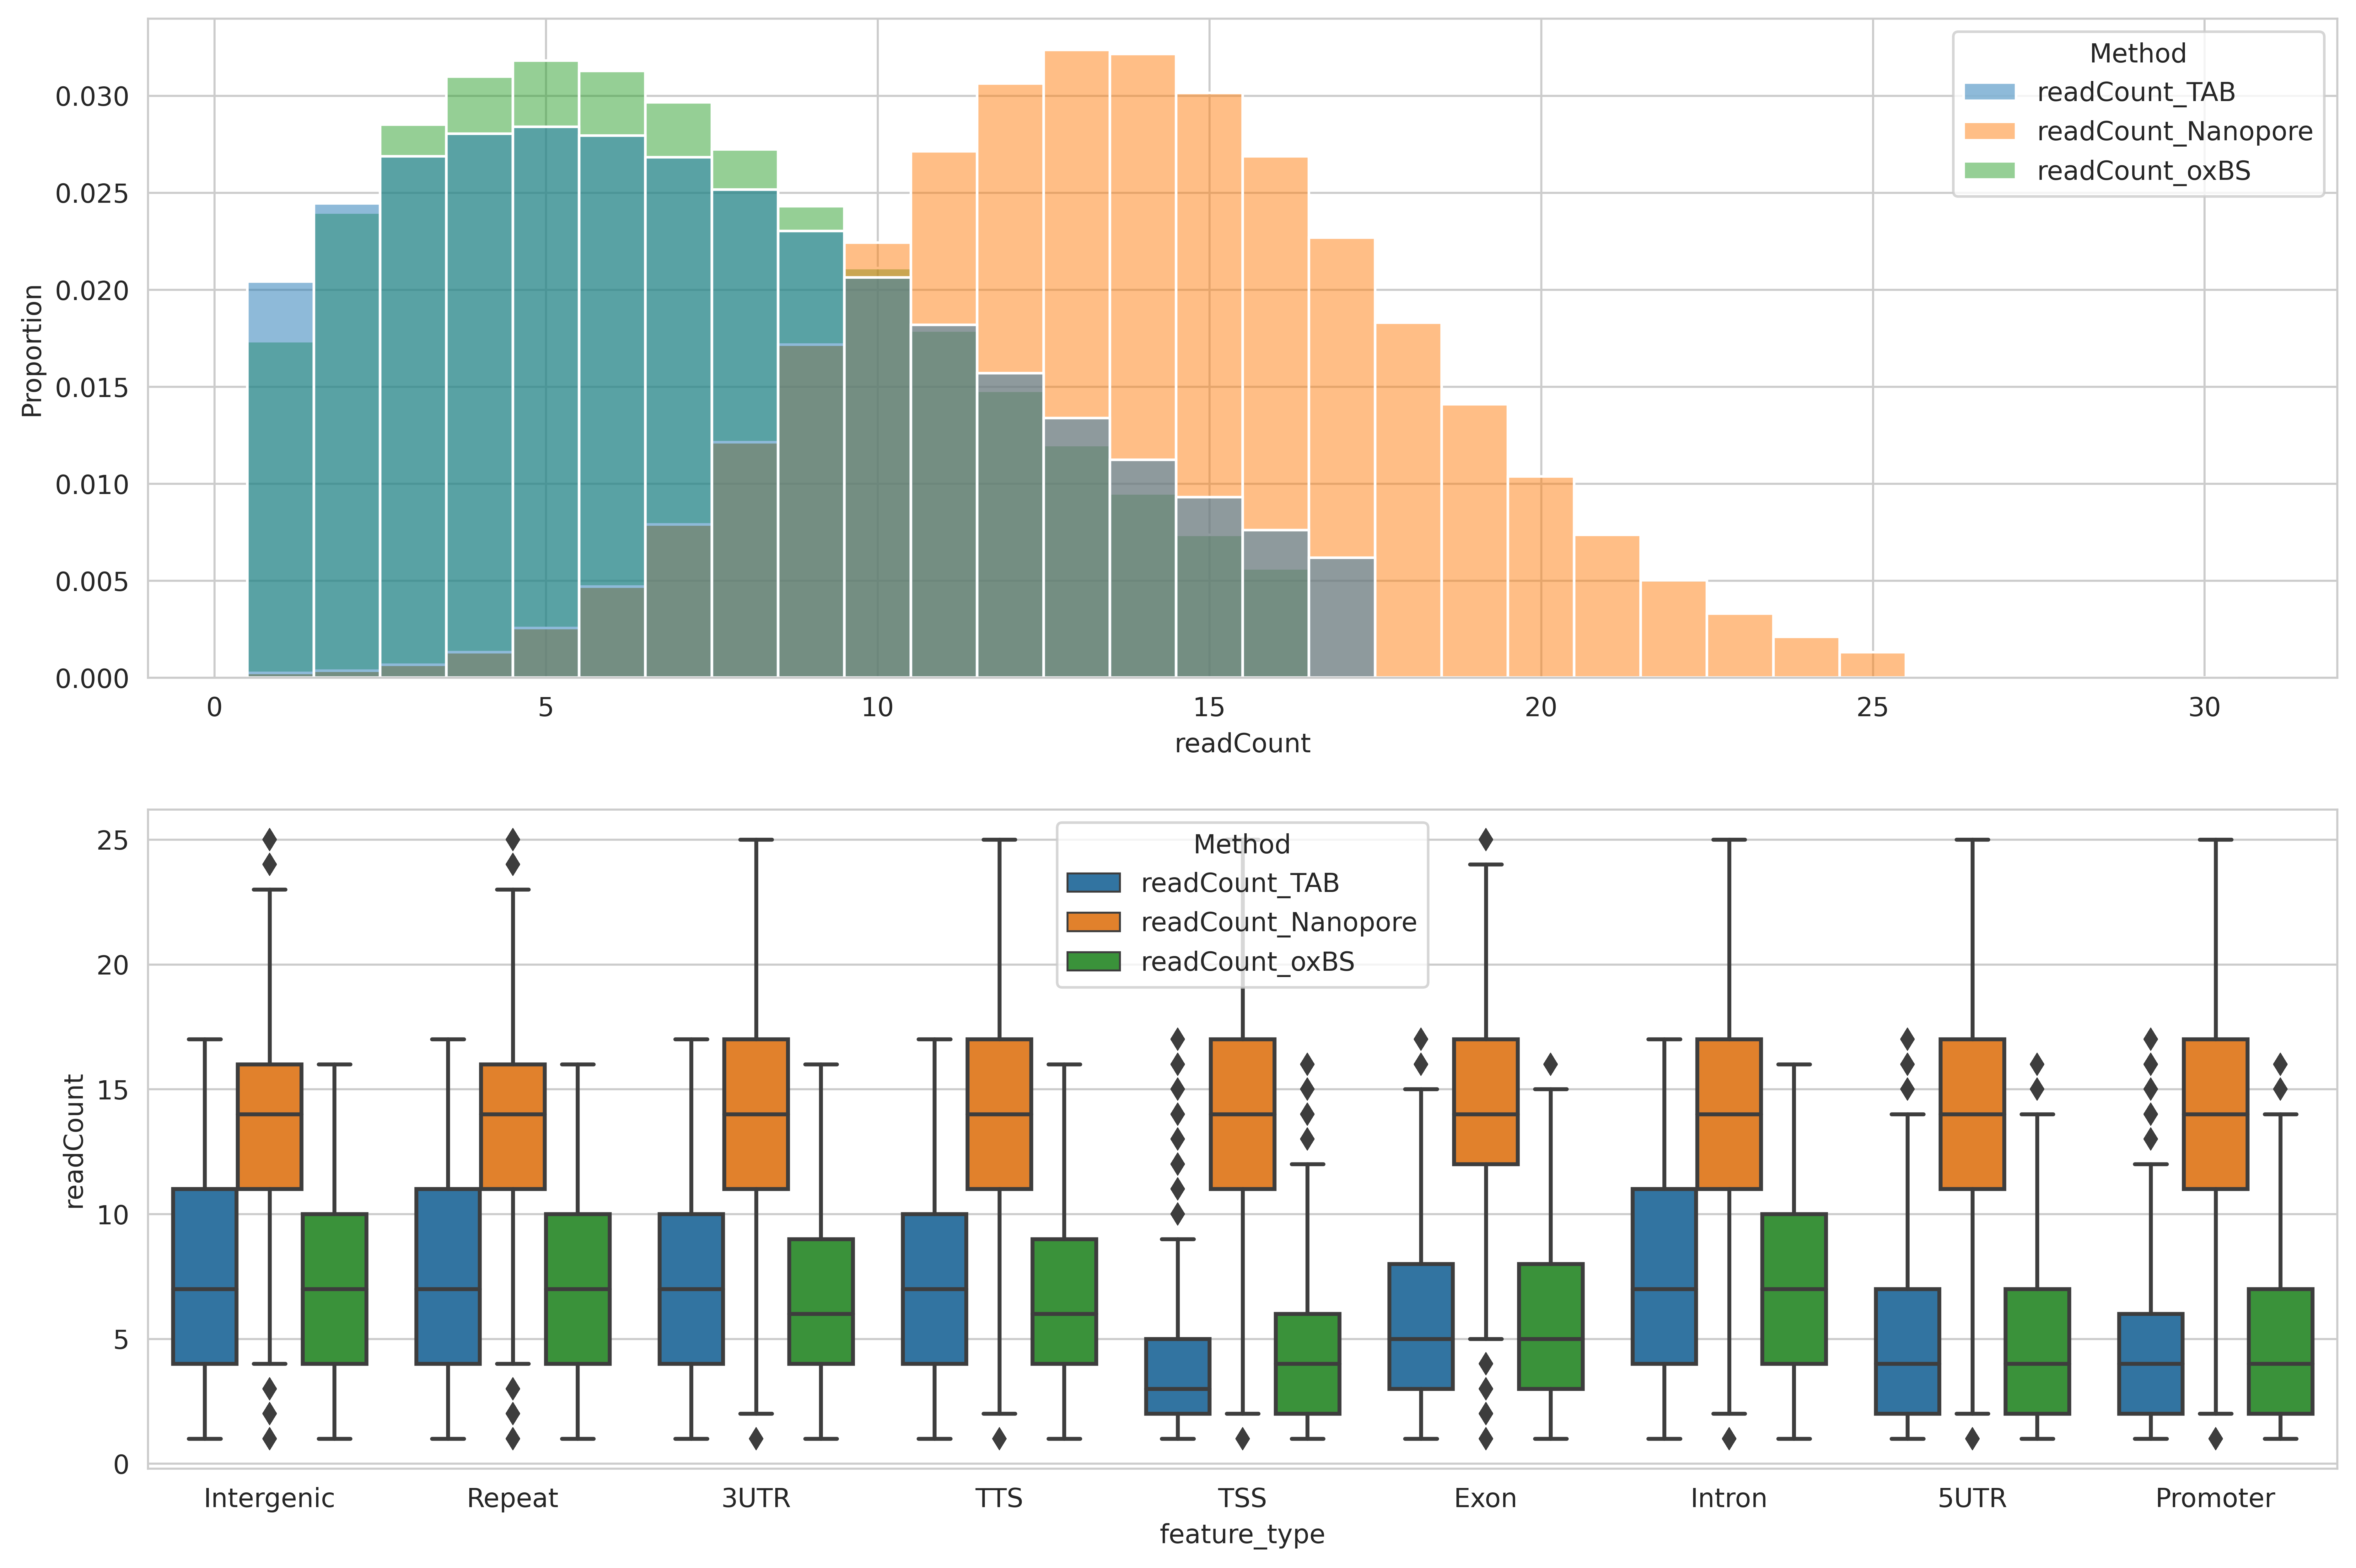

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_style("whitegrid")

fig, axes = plt.subplots(2, 1, figsize=(15, 10), dpi=600)

sns.histplot(readcount_features_df, x="readCount", stat="proportion", hue="Method", discrete=True, binwidth=1, binrange=(1, 30), ax=axes[0])
sns.boxplot(readcount_features_df, x="feature_type", y="readCount", hue="Method", dodge=True, ax=axes[1])

# Figure 1

In [2]:
import pandas as pd
prom_comp_data = pd.read_csv("intermediates/revised_01.08/prom_tab_oxBS_comparison_data.tsv", sep="\t")

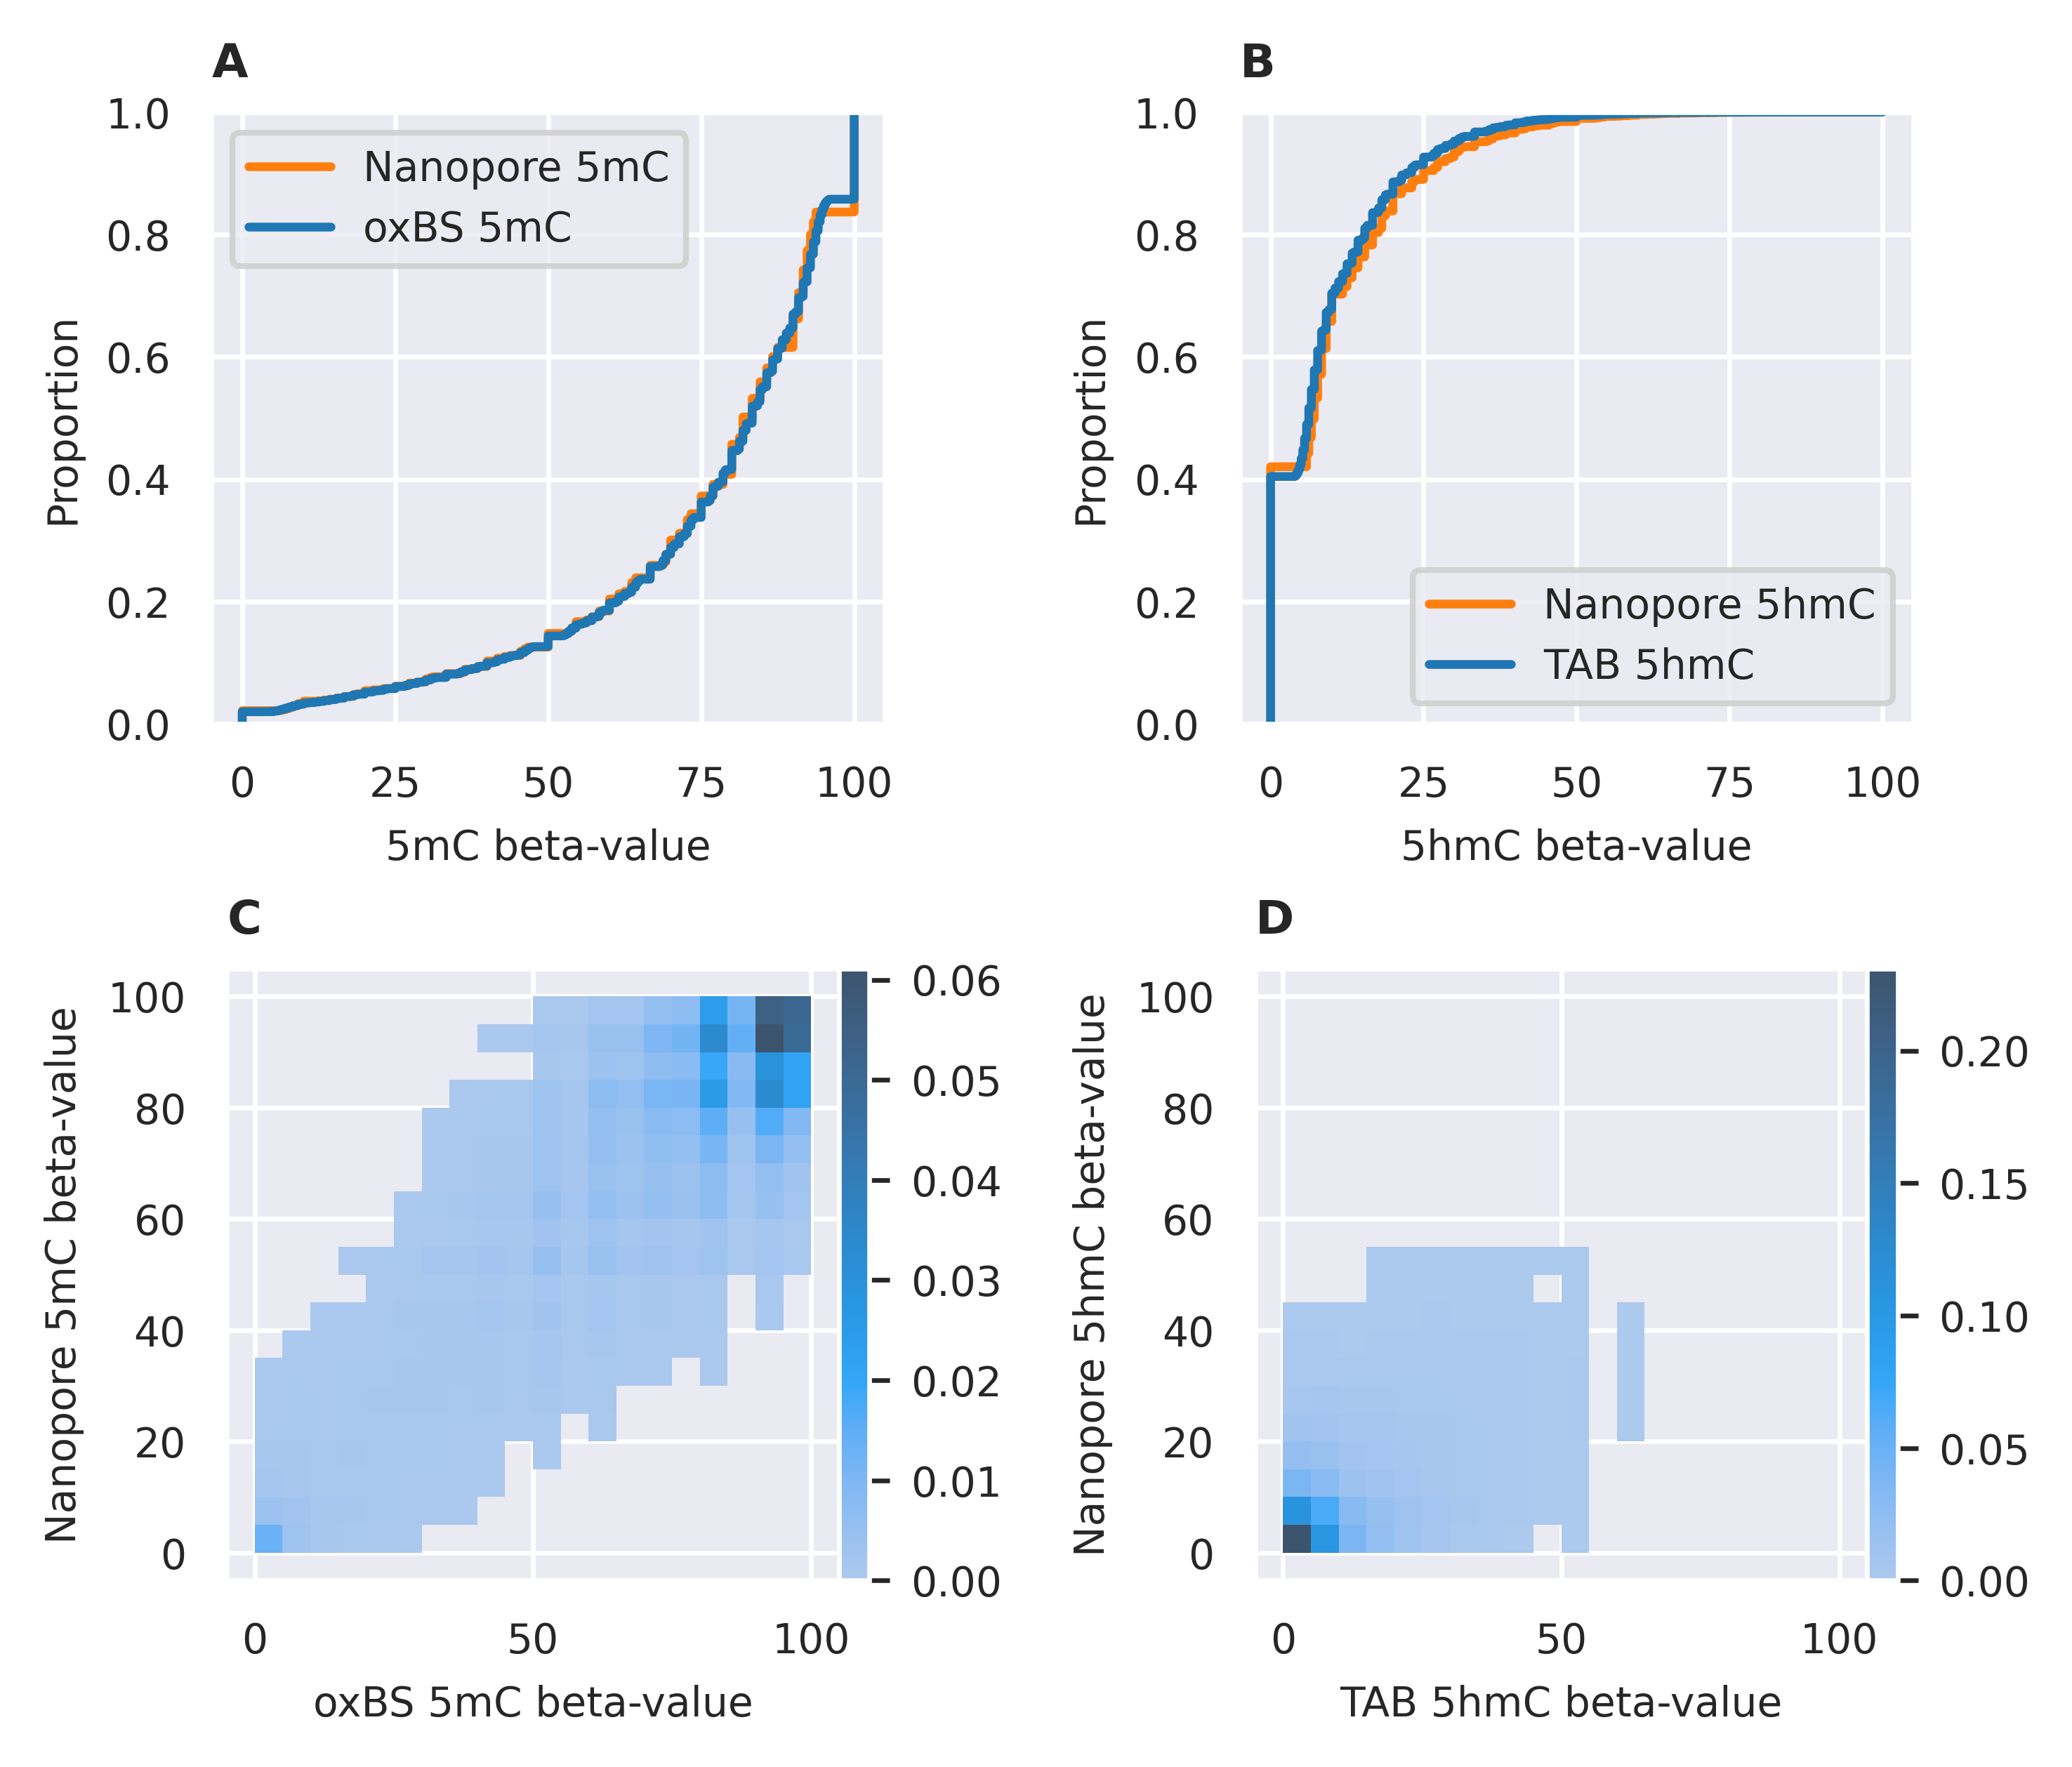

In [103]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

sns.set_style("darkgrid")
mpl.rc('font', size=7)

fig = plt.figure(figsize=((180)/25.4, 115/25.4), dpi=600)

ax1 = plt.subplot2grid((2, 2), (0, 0))
ax2 = plt.subplot2grid((2, 2), (0, 1))
ax3 = plt.subplot2grid((2, 2), (1, 0))
ax4 = plt.subplot2grid((2, 2), (1, 1))

comparison = [["percentMeth_5mC_Prom", "percentMeth_5mC_Bisulphite"], ["percentMeth_5hmC_Prom", "percentMeth_5hmC_Bisulphite"]]
legends = [["Nanopore 5mC", "oxBS 5mC"], ["Nanopore 5hmC", "TAB 5hmC"]]

for index, ax in enumerate([ax1, ax2]):
    sns.ecdfplot(prom_comp_data.melt(
        id_vars=["chromosome", "chromStart", "chromEnd"], value_vars=comparison[index], var_name="method", value_name="percentMeth"),
    x="percentMeth", hue="method", ax=ax)
    ax.set_aspect(100)

ax1.set_xlabel("5mC beta-value")
ax1.legend(labels=legends[0], title=None, loc="upper left")
ax1.set_title("A", loc="left", fontsize=8, fontweight="bold")

ax2.set_xlabel("5hmC beta-value")
ax2.legend(labels=legends[1], title=None, loc="lower right")
ax2.set_title("B", loc="left", fontsize=8, fontweight="bold")

for index, ax in enumerate([ax3, ax4]):
    div = make_axes_locatable(ax)
    cax = div.append_axes("right", size="5%", pad=0)
    sns.histplot(prom_comp_data, x=comparison[index][1], y=comparison[index][0], stat="proportion", binwidth=5, pthresh=0.01, cbar=True, ax=ax, cbar_ax=cax)
    ax.set_aspect("equal")

ax3.set_xlabel("oxBS 5mC beta-value")
ax3.set_ylabel("Nanopore 5mC beta-value")
ax3.set_title("C", loc="left", fontsize=8, fontweight="bold")

ax4.set_xlabel("TAB 5hmC beta-value")
ax4.set_ylabel("Nanopore 5hmC beta-value")
ax4.set_title("D", loc="left", fontsize=8, fontweight="bold")

fig.subplots_adjust(wspace=-0.2, hspace=0.4)
fig.show()

In [4]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

comparison = [["percentMeth_5mC_Prom", "percentMeth_5mC_Bisulphite"], ["percentMeth_5hmC_Prom", "percentMeth_5hmC_Bisulphite"]]

for comp in comparison:
    x = prom_comp_data[comp[1]].to_numpy().reshape(-1, 1)
    y = prom_comp_data[comp[0]].to_numpy().reshape(-1, 1)

    model.fit(x, y)
    print(f"Model for {comp[0]} ~ {comp[1]}: {round(float(model.intercept_), 3)} + {round(float(model.coef_), 3)}X; R$^{2}$={round(float(model.score(x, y)), 3)}")

Model for percentMeth_5mC_Prom ~ percentMeth_5mC_Bisulphite: 15.79 + 0.793X; R$^2$=0.639
Model for percentMeth_5hmC_Prom ~ percentMeth_5hmC_Bisulphite: 4.422 + 0.435X; R$^2$=0.241


### Comparison vs. MLML

Note: It doesn't appear possible to compare the MLML-standardised oxBS/TAB dataset. 5hmC appears vastly overpredicted. 

In [2]:
import pandas as pd
from common import readModbam2bed

prom_data = readModbam2bed("/mnt/data1/doh28/data/prom_R10.4.1_E8.2_WGS_brain_DH/dorado_0.3.2_basecalls/cbm1_prom_modbases_mapq60.bed")
mlml_tab_ox = pd.read_csv("/mnt/data1/doh28/data/MLML_datasets/dnmtools_mlml_oxBS_TAB_10x.tsv", sep="\t", names=[
    "chromosome", "chromStart", "chromEnd", "percentMeth_5mC", "percentMeth_5hmC", "percentMeth_C", "N_conflicts"
])

In [3]:
mlml_tab_ox_c = mlml_tab_ox.copy().query("N_conflicts < 1")

In [4]:
mlml_tab_ox_c.loc[:, ("percentMeth_5mC", "percentMeth_5hmC", "percentMeth_C")] = mlml_tab_ox_c.loc[:, ("percentMeth_5mC", "percentMeth_5hmC", "percentMeth_C")].transform(lambda x: x*100)

In [5]:
merged_prom_mlm = pd.merge(prom_data, mlml_tab_ox_c, "inner", ["chromosome", "chromStart", "chromEnd"], suffixes=["_Nanopore", "_Bisulphite"])

<Axes: xlabel='percentMeth_5mC_Bisulphite', ylabel='percentMeth_5mC_Nanopore'>

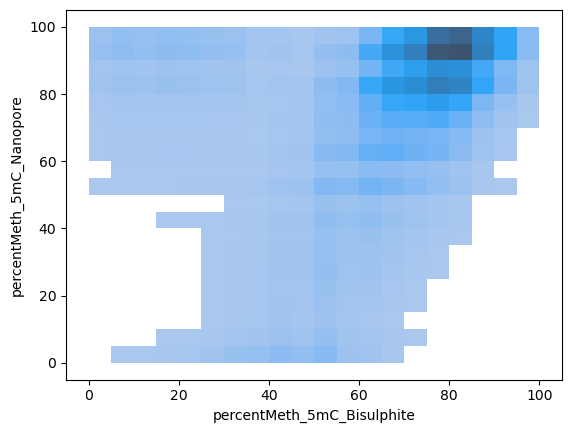

In [16]:
import seaborn as sns

sns.histplot(merged_prom_mlm, x="percentMeth_5mC_Bisulphite", y="percentMeth_5mC_Nanopore", bins=20, pthresh=0.01)

In [25]:
from common import readBismarkZeroCov
tab = readBismarkZeroCov("../../data/CRR008807_TAB/mapq_filtered/modified_bases/CRR008807_TAB_merged_resorted_q10.bedGraph.gz.bismark.zero.cov", "5hmC")

In [34]:
tab_mlm = pd.merge(tab, mlml_tab_ox_c, "inner", ["chromosome", "chromStart", "chromEnd"], suffixes=["_TAB", "_MLML"])
tab_prom = pd.merge(tab, prom_data, "inner", ["chromosome", "chromStart", "chromEnd"], suffixes=["_TAB", "Prom"])


<Axes: xlabel='percentMeth_5hmC_TAB', ylabel='percentMeth_5hmCProm'>

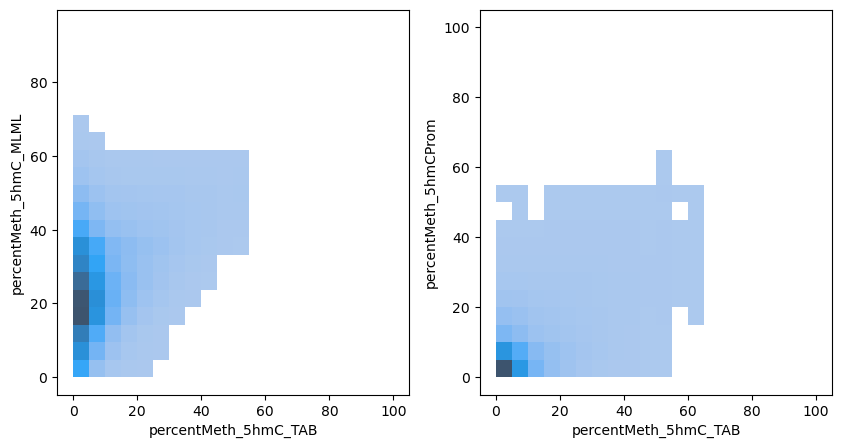

In [38]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.histplot(tab_mlm, x="percentMeth_5hmC_TAB", y="percentMeth_5hmC_MLML", bins=20, pthresh=0.01, ax=axes[0])
sns.histplot(tab_prom, x="percentMeth_5hmC_TAB", y="percentMeth_5hmCProm", bins=20, pthresh=0.01, ax=axes[1])

Even the raw TAB data looks awful compared to the MLML version as MLML appears to overestimate the amount of 5hmC. The beta-values of oxBS and TAB are added and subtracted from 1. The remainder is assumed to be unmodified C. This dataset appears to have very low unmodified C with very high 5hmC - reflecting that oxBS and TAB are abnormally high. 

This unfortunately means I can't use this method for a confusion matrix. 

# Figure 2


In [1]:
import pandas as pd
prom_comp_data = pd.read_csv("intermediates/revised_01.08/prom_tab_oxBS_comparison_data.tsv", sep="\t")

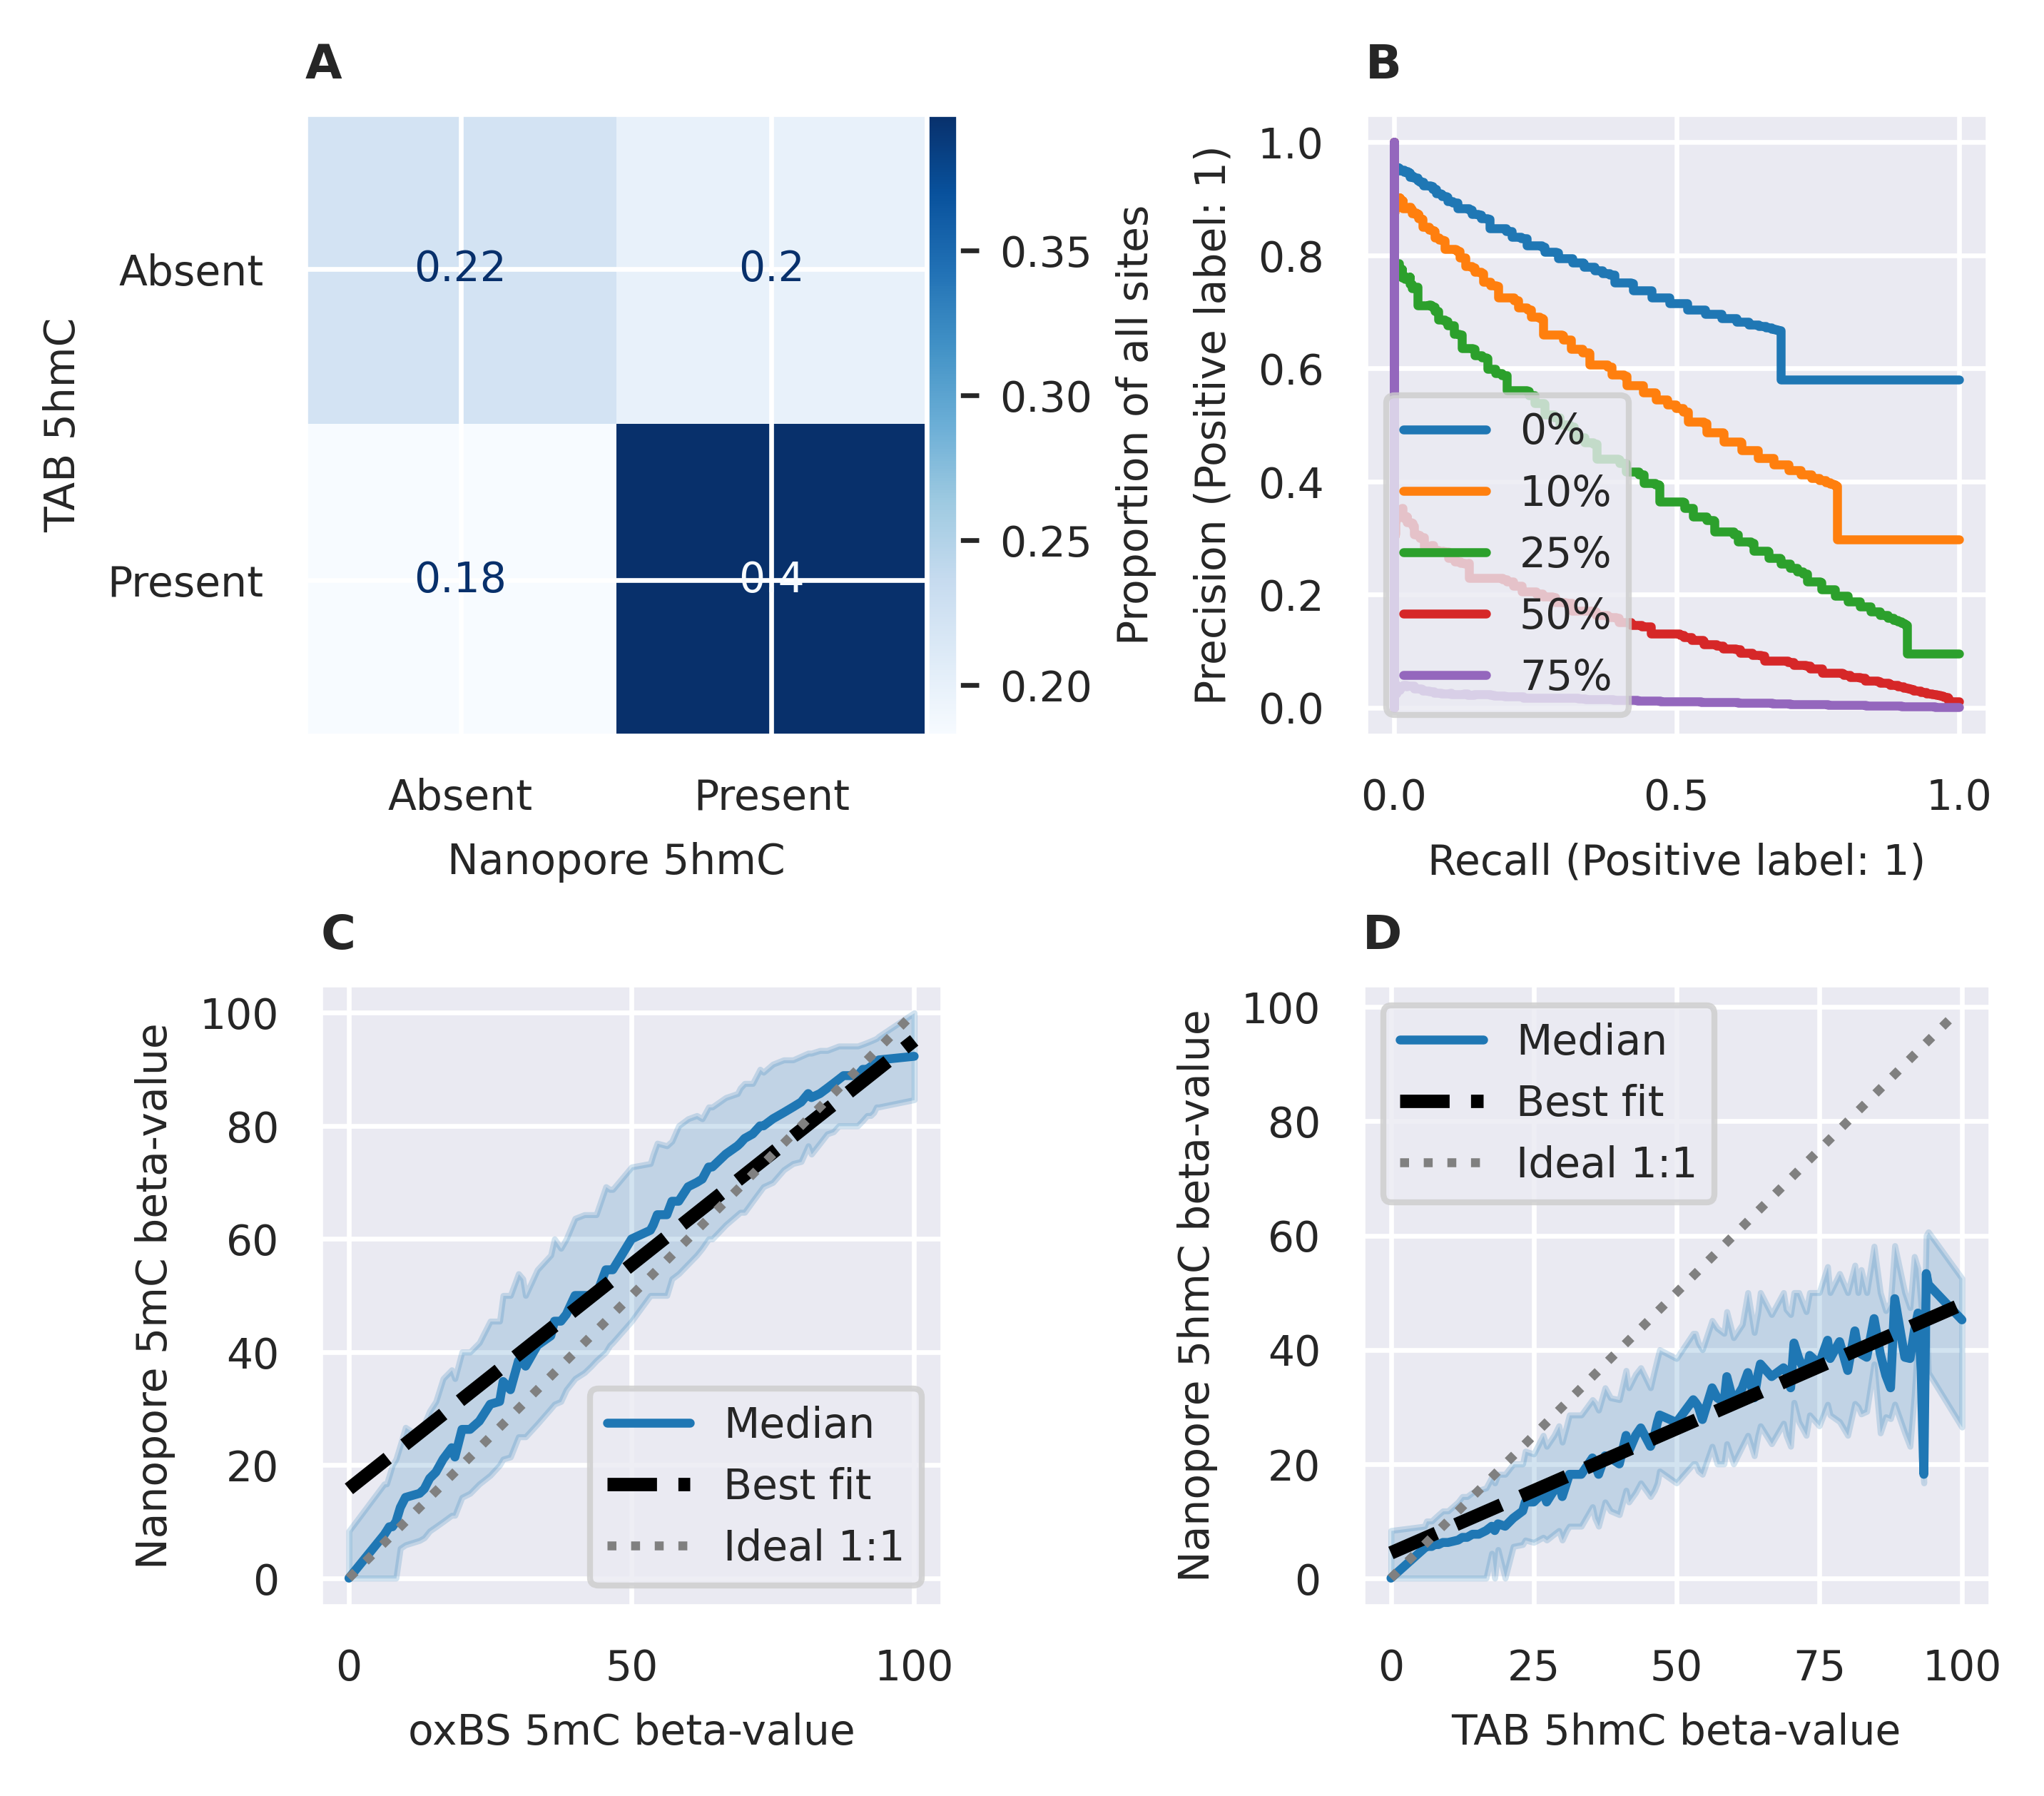

In [110]:
import seaborn as sns
import matplotlib as mpl 
import matplotlib.pyplot as plt 
from mpl_toolkits.axes_grid1 import make_axes_locatable

sns.set_style("darkgrid")
mpl.rc('font', size=7)

fig = plt.figure(figsize=((180)/25.4, 115/25.4), dpi=600)

ax1 = plt.subplot2grid((2, 2), (0, 0))
ax2 = plt.subplot2grid((2, 2), (0, 1))
ax3 = plt.subplot2grid((2, 2), (1, 0))
ax4 = plt.subplot2grid((2, 2), (1, 1))

div = make_axes_locatable(ax1)
cax = div.append_axes("right", size="5%", pad=0)

binarizer = Binarizer(threshold=0)
true_b, pred_b = binarizer.fit_transform(true), binarizer.fit_transform(pred)
cm = metrics.ConfusionMatrixDisplay.from_predictions(true_b, pred_b, display_labels=["Absent", "Present"], normalize="all", colorbar=False, cmap="Blues", im_kw={"origin" : "lower"}, ax=ax1)

fig.colorbar(cm.im_, cax, label="Proportion of all sites")
ax1.set_xlabel("Nanopore 5hmC")
ax1.set_ylabel("TAB 5hmC")
ax1.set_title("A", loc="left", fontsize=8, fontweight="bold")

for value in [0, 10, 25, 50, 75]:
    binarizer = Binarizer(threshold=value) 
    true_b = binarizer.fit_transform(true)
    # print(metrics.roc_auc_score(true_b, pred))
    metrics.PrecisionRecallDisplay.from_predictions(true_b, pred, label=f"{value}%",  ax=ax2)

ax2.set_aspect("equal")
ax2.set_title("B", loc="left", fontsize=8, fontweight="bold")

comparison = [["percentMeth_5mC_Prom", "percentMeth_5mC_Bisulphite"], ["percentMeth_5hmC_Prom", "percentMeth_5hmC_Bisulphite"]]

for index, ax in enumerate([ax3, ax4]):
    sns.lineplot(prom_comp_data, x=comparison[index][1], y=comparison[index][0], label="Median", estimator='median', errorbar=("pi", 50), ax=ax)
    sns.regplot(prom_comp_data, x=comparison[index][1], y=comparison[index][0], ci=None, color="black", line_kws={"ls" : "--"}, label="Best fit", scatter=False, ax=ax)
    ax.plot(np.arange(0, 100, 1), np.arange(0, 100, 1), c="grey", ls=":", label="Ideal 1:1")
    ax.set_aspect("equal")
    ax.legend()

ax3.set_xlabel("oxBS 5mC beta-value")
ax3.set_ylabel("Nanopore 5mC beta-value")
ax3.set_title("C", loc="left", fontsize=8, fontweight="bold")

ax4.set_xlabel("TAB 5hmC beta-value")
ax4.set_ylabel("Nanopore 5hmC beta-value")
ax4.set_title("D", loc="left", fontsize=8, fontweight="bold")

fig.subplots_adjust(wspace=-0.2, hspace=0.4)
fig.show()

# Figure 3

In [ ]:
import pandas as pd
from common import get_bismark, get_wgbs, filterDepth
import numpy as np
    
prediction_data = pd.read_csv('./DNMTools_datasets/dnmtools_mlml_oxBS_WGBS.text', sep="\t", 
                           names=["chromosome", "chromStart", "chromEnd", "percentMeth_mC", "percentMeth_hmC", "percentMeth_C", "N_conflicts"]).query("N_conflicts == 0")

nano_all = pd.read_csv("./intermediates/nanopore_three_mod.tsv", sep="\t", names=["chromosome", "chromStart", "chromEnd", "percentMeth_mC", "percentMeth_C", "percentMeth_hmC"])
nano_v_predicted = pd.merge(nano_all, prediction_data, "inner", ["chromosome", "chromStart", "chromEnd"], suffixes=["_Nanopore", "_MLML"])

tab_data = filterDepth(get_bismark('./data/TAB_data/CRR008807_TAB_merged.bedGraph.gz.bismark.zero.cov', "5hmC"))
tab_data_v_predicted = pd.merge(tab_data, prediction_data, "inner", ["chromosome", "chromStart", "chromEnd"], suffixes=["_TAB", "_MLML"]).rename(
    columns={"percentMeth" : "percentMeth_hmC_TAB",
             "percentMeth_mC" : "percentMeth_mC_MLML",
             "percentMeth_hmC" : "percentMeth_hmC_MLML",
             "percentMeth_C" : "percentMeth_C_MLML"}
)
tab_data_v_predicted["percentMeth_hmC_TAB"] = tab_data_v_predicted["percentMeth_hmC_TAB"].div(100)

In [ ]:
wgbs_data = filterDepth(get_wgbs('./data/WGBS_data/mm39_ENCSR893RHD_merged.bed'))
oxbs_data = filterDepth(get_bismark("./data/oxBS_data/CRR008808_oxBS_remergedRaw.zero.cov_modified.bed", "5mC"))

subtraction_data = pd.merge(oxbs_data, wgbs_data, "inner", ["chromosome", "chromStart", "chromEnd"], suffixes=["_oxBS", "_WGBS"])
subtraction_data["percentMeth_hmC_subtraction"] = subtraction_data["percentMeth_WGBS"].subtract(subtraction_data["percentMeth_oxBS"])
subtraction_data["percentMeth_C_subtraction"] = np.subtract(100, subtraction_data["percentMeth_WGBS"])

subtraction_data_rel = pd.merge(subtraction_data, tab_data, "inner", ["chromosome", "chromStart", "chromEnd"], suffixes=["_subtraction", "_TAB"]).rename(columns={"percentMeth" : "percentMeth_5hmC_TAB"})

In [ ]:
from sklearn import preprocessing
from Checkpoints import Checkpoint

subtraction_data_rel["bin"] = pd.cut(subtraction_data_rel["percentMeth_5hmC_TAB"], 101, labels=np.arange(0, 101, 1))
nano_v_predicted["bin"] = pd.cut(nano_v_predicted["percentMeth_hmC_MLML"], 101, labels=np.arange(0, 101, 1))
tab_data_v_predicted["bin"] = pd.cut(tab_data_v_predicted["percentMeth_hmC_TAB"], 101, labels=np.arange(0, 101, 1))

binariser_big = preprocessing.Binarizer(threshold=50)
binariser_small = preprocessing.Binarizer(threshold=0.50)

if not "hmc_df_wide" in locals():
    hmc_df_wide = Checkpoint(path="./intermediates/hmc_df_wide.tsv").loadCheckpoint()

hmc_df_wide["binarised"] = binariser_big.fit_transform(np.reshape(hmc_df_wide["percentMeth_TAB_5hmC"].to_numpy(), (-1, 1)))
subtraction_data_rel["binarised"] = binariser_big.fit_transform(np.reshape(subtraction_data_rel["percentMeth_5hmC_TAB"].to_numpy(), (-1, 1)))
nano_v_predicted["binarised"] = binariser_small.fit_transform(np.reshape(nano_v_predicted["percentMeth_hmC_MLML"].to_numpy(), (-1, 1)))
tab_data_v_predicted["binarised"] = binariser_small.fit_transform(np.reshape(tab_data_v_predicted["percentMeth_hmC_TAB"].to_numpy(), (-1, 1)))

In [ ]:
def getPred(df, kind):
    if kind == "Nanopore":
        df["pred"] = df[["percentMeth_C_Nanopore", "percentMeth_mC_Nanopore", "percentMeth_hmC_Nanopore"]].idxmax(axis="columns").replace(
            ["percentMeth_C_Nanopore", "percentMeth_mC_Nanopore", "percentMeth_hmC_Nanopore"], ["C", "5mC", "5hmC"]
            )
    elif kind == "MLML":
        df["pred"] = df[["percentMeth_C_MLML", "percentMeth_mC_MLML", "percentMeth_hmC_MLML"]].idxmax(axis="columns").replace(
            ["percentMeth_C_MLML", "percentMeth_mC_MLML", "percentMeth_hmC_MLML"], ["C", "5mC", "5hmC"]
            )

    return df["pred"]
    
def getTrue(df, kind):
    if kind == "TAB":
        df["true"] = df[["percentMeth_C_TAB", "percentMeth_mC_TAB", "percentMeth_hmC_TAB"]].idxmax(axis="columns").replace(
            ["percentMeth_C_TAB", "percentMeth_mC_TAB", "percentMeth_hmC_TAB"], ["C", "5mC", "5hmC"]
            )
    elif kind == "MLML":
        df["true"] = df[["percentMeth_C_MLML", "percentMeth_mC_MLML", "percentMeth_hmC_MLML"]].idxmax(axis="columns").replace(
            ["percentMeth_C_MLML", "percentMeth_mC_MLML", "percentMeth_hmC_MLML"], ["C", "5mC", "5hmC"]
            )
    elif kind == "Nanopore":
        df["true"] = df[["percentMeth_C_Nanopore", "percentMeth_mC_Nanopore", "percentMeth_hmC_Nanopore"]].idxmax(axis="columns").replace(
            ["percentMeth_C_Nanopore", "percentMeth_mC_Nanopore", "percentMeth_hmC_Nanopore"], ["C", "5mC", "5hmC"]
            )
    return df["true"]

In [ ]:
dnmtools_out = pd.read_csv('./DNMTools_datasets/dnmtools_mlml_All.text', sep="\t", 
                           names=["chromosome", "chromStart", "chromEnd", "percentMeth_mC", "percentMeth_hmC", "percentMeth_C", "N_conflicts"]).query("N_conflicts == 0")

tab_vs_predicted_CM = dnmtools_out.merge(prediction_data, "inner", ["chromosome", "chromStart", "chromEnd"], suffixes=["_TAB", "_MLML"])
# nano_vs_predicted_CM = dnmtools_out.merge(nano_all, "inner", ["chromosome", "chromStart", "chromEnd"], suffixes=["_TAB", "_Nanopore"])
# nano_vs_mlml_CM = prediction_data.merge(nano_all, "inner", ["chromosome", "chromStart", "chromEnd"], suffixes=["_MLML", "_Nanopore"])

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from graphing import linePlot
# from sklearn.metrics import ConfusionMatrixDisplay
# from mpl_toolkits.axes_grid1 import make_axes_locatable

##### Figure 3 ##### 

fig3 = plt.figure("fig3", figsize=(10, 5), dpi=600)
gs3 = GridSpec(1, 2)

sns.set_style("whitegrid")

##### ax00 ##### 

ax00 = fig3.add_subplot(gs3[0, 0])
ax00.set_aspect("equal")

ax00.plot(np.arange(0, 101, 1), "black", linestyle=":")
sns.lineplot(hmc_df_wide, x="percentMeth_TAB_5hmC", y="percentMeth_Nanopore_5hmC", errorbar=("pi", 50), ls="-", label="Nanopore (Y) vs. TAB", ax=ax00)
sns.lineplot(subtraction_data_rel, x="percentMeth_5hmC_TAB", y="percentMeth_hmC_subtraction", errorbar=("pi", 50), ls="--", label="Subtraction (Y) vs. TAB", ax=ax00)
sns.lineplot(x=tab_data_v_predicted["percentMeth_hmC_TAB"]*100, y=tab_data_v_predicted["percentMeth_hmC_MLML"]*100, errorbar=("pi", 50), ls="-.", label="MLML (Y) vs. TAB", ax=ax00)
# sns.lineplot(x=nano_v_predicted["bin"], y=nano_v_predicted["percentMeth_hmC_Nanopore"]*100, errorbar=("pi", 50), ls=":", label="MLML vs. Nanopore", ax=ax00)

ax00.set_title("A", loc="left")
ax00.legend()
ax00.set_xlabel("TAB \u03B2$_{\%}$")
ax00.set_ylabel("Compared method \u03B2$_{\%}$")

##### ax01 ##### 

from graphing import ROCPlot
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

ax01 = fig3.add_subplot(gs3[0, 1])

RocCurveDisplay.from_predictions(hmc_df_wide["binarised"], hmc_df_wide["percentMeth_Nanopore_5hmC"], label="Nanopore vs. TAB", ls="-", ax=ax01)
RocCurveDisplay.from_predictions(subtraction_data_rel["binarised"], subtraction_data_rel["percentMeth_hmC_subtraction"], label="Subtraction vs. TAB", ls="--", ax=ax01)
RocCurveDisplay.from_predictions(tab_data_v_predicted["binarised"], tab_data_v_predicted["percentMeth_hmC_MLML"], label="MLML vs. TAB", ls="-.", ax=ax01)
# RocCurveDisplay.from_predictions(nano_v_predicted["binarised"], nano_v_predicted["percentMeth_hmC_Nanopore"], label="MLML vs. Nanopore", ls=":", ax=ax01)

ax01.set_title("B", loc="left")
ax01.legend()

##### ax1 ##### 

# ax1 = fig3.add_subplot(gs3[1, 1:3])
# cm1 = ConfusionMatrixDisplay.from_predictions(getTrue(tab_vs_predicted_CM, "TAB"), getPred(tab_vs_predicted_CM, "MLML"), normalize="true", cmap="Greens", colorbar=False, ax=ax1)
# div1 = make_axes_locatable(ax1)
# cax1 = div1.append_axes("right", size="5%", pad=0.05)

# fig3.colorbar(cm1.im_, cax1, label="Proportion of labels\n(normalised on TAB labels)")

# ax1.set_title("C", loc="left")
# ax1.set_xlabel("TAB dominant state")
# ax1.set_ylabel("MLML dominant state")

##### Save Figure ##### 

fig3.tight_layout()
fig3.savefig('/u/n/doh28/Documents/Nanopore_HMC/Figures/Figure3.png', bbox_inches="tight")
plt.close()

## Figure 3 Stats

In [ ]:
from scipy import stats
from sklearn import metrics

def mean_signed_deviation(est, pred):
    msd = np.average(pred - est)
    return msd

orig_comp = [hmc_df_wide["percentMeth_TAB_5hmC"], hmc_df_wide["percentMeth_Nanopore_5hmC"]]
tab_comp = [tab_data_v_predicted["percentMeth_hmC_TAB"], tab_data_v_predicted["percentMeth_hmC_MLML"]]
subtraction_comp = [subtraction_data_rel["percentMeth_5hmC_TAB"], subtraction_data_rel["percentMeth_hmC_subtraction"]]
nano_comp = [nano_v_predicted["percentMeth_hmC_MLML"], nano_v_predicted["percentMeth_hmC_Nanopore"]]

print(f"TAB vs. Nanopore: r={stats.pearsonr(*orig_comp).statistic}\tSpearman p={stats.spearmanr(*orig_comp).statistic}\tMAD={metrics.mean_absolute_error(*orig_comp)}\tRMSE={metrics.mean_squared_error(*orig_comp, squared=False)}\tMSD={mean_signed_deviation(*orig_comp)}\n\
        MLML vs. TAB: r={stats.pearsonr(*tab_comp).statistic}\tSpearman p={stats.spearmanr(*tab_comp).statistic}\tMAD={metrics.mean_absolute_error(*tab_comp)}\tRMSE={metrics.mean_squared_error(*tab_comp, squared=False)}\tMSD={mean_signed_deviation(*tab_comp)}\n\
        MLML vs. Nanopore: r={stats.pearsonr(*nano_comp).statistic}\tSpearman p={stats.spearmanr(*nano_comp).statistic}\tMAD={metrics.mean_absolute_error(*nano_comp)}\tRMSE={metrics.mean_squared_error(*nano_comp, squared=False)}\tMSD={mean_signed_deviation(*nano_comp)}\n\
        Subtraction vs. TAB: r={stats.pearsonr(*subtraction_comp).statistic}\tSpearman p={stats.spearmanr(*subtraction_comp).statistic}\tMAD={metrics.mean_absolute_error(*subtraction_comp)}\tRMSE={metrics.mean_squared_error(*subtraction_comp, squared=False)}\tMSD={mean_signed_deviation(*subtraction_comp)}")

TAB vs. Nanopore: r=0.5291749303121095	Spearman p=0.419630433268654	MAD=8.818819090387006	RMSE=12.454925338220514	MSD=-0.21194548358786908
        MLML vs. TAB: r=0.37481546204681865	Spearman p=0.2617466174264021	MAD=0.0913354572338189	RMSE=0.12862253766918755	MSD=-0.005083490946388437
        MLML vs. Nanopore: r=0.3084148353640208	Spearman p=0.21863025666999789	MAD=0.094292091829717	RMSE=0.13062199369706842	MSD=0.009329907029727596
        Subtraction vs. TAB: r=0.34552380960980067	Spearman p=0.2554517563529673	MAD=11.430213240088747	RMSE=15.003716423109047	MSD=-2.9702134957173247


In [ ]:
from sklearn import metrics

metrics.cohen_kappa_score(getTrue(tab_vs_predicted_CM, "TAB"), getPred(tab_vs_predicted_CM, "MLML")) #,  metrics.cohen_kappa_score(getTrue(nano_vs_mlml_CM, "Nanopore"), getPred(nano_vs_mlml_CM, "MLML"))

(0.8954658657657534, 0.7291478353074418)

In [ ]:
metrics.roc_auc_score(hmc_df_wide["binarised"], hmc_df_wide["percentMeth_Nanopore_5hmC"]), metrics.roc_auc_score(subtraction_data_rel["binarised"], subtraction_data_rel["percentMeth_hmC_subtraction"]), metrics.roc_auc_score(tab_data_v_predicted["binarised"], tab_data_v_predicted["percentMeth_hmC_MLML"])

(0.8941589833588693, 0.8569679301432648, 0.8566796628913436)

In [ ]:
ROCPlot(hmc_df_wide, 66).calculateAUC(), ROCPlot(nano_v_predicted, 0.66).calculateAUC(), ROCPlot(tab_data_v_predicted, 66).calculateAUC(), ROCPlot(subtraction_data_rel, 66).calculateAUC()

(0.9084987154472722, 0.8997360513642245, 0.884852459851316, 0.8854412015770458)

# Figure 4

In [ ]:
import pandas as pd

hmc_df_wide = pd.read_csv("./intermediates/hmc_df_wide.tsv", sep="\t", names=["Chromosome", "Start", "End", "strand", "readCount_Nanopore", "percentMeth_Nanopore_5hmC", "readCount_TAB", "percentMeth_Bisulphite_5hmC"]).drop(columns=["readCount_Nanopore", "readCount_TAB"])

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from Checkpoints import Checkpoint
from mpl_toolkits.axes_grid1 import make_axes_locatable
from GroupCpGs import *
import numpy as np

In [ ]:
##### Figure 5 #####

sns.set_style("whitegrid")
sns.set_palette(sns.color_palette("Paired")[2:4])

fig5 = plt.figure(figsize=(10, 12), dpi=600)
gs5 = GridSpec(3, 2, fig5, height_ratios=(2, 2, 3))

##### ax0 ##### 

ax0 = fig5.add_subplot(gs5[0, :2])

group_df_feature = FeatureAndGene(CpGIntersects(hmc_df_wide).group("features")).asLongDf()
sns.violinplot(group_df_feature, x="feature_type", y="percentMeth", hue="method", split=False, ax=ax0)
ax0.set_title("A", loc="left")
ax0.set_ylim(0, 50)
ax0.set_xlabel("Genomic feature")
ax0.set_ylabel("Average CpG 5hmC \u03B2$_{\%}$")
sns.move_legend(ax0, "upper left", title=None)

##### ax1 ##### 

ax1 = fig5.add_subplot(gs5[1, :2])

group_df_cgi = FeatureAndGene(CpGIntersects(hmc_df_wide).group("CGI")).asLongDf()
sns.violinplot(group_df_cgi, x="feature_type", y="percentMeth", hue="method", split=False, ax=ax1)
ax1.set_title("B", loc="left")
ax1.set_ylim(0, 50)
ax1.set_xlabel("Position relative to CGI")
ax1.set_ylabel("Average CpG 5hmC \u03B2$_{\%}$")
sns.move_legend(ax1, "upper left", title=None)

##### ax20 #####

ax20 = fig5.add_subplot(gs5[2, 0])
gene_data = FeatureAndGene(CpGIntersects(hmc_df_wide).group("genes"), 10)
div20 = make_axes_locatable(ax20)
cax20 = div20.append_axes("right", size="5%", pad=0.05)

gene_data.makeHist("density", ax20, cax20)

ax20.set_title("C", loc="left")

##### ax21 ##### 

ax21 = fig5.add_subplot(gs5[2, 1])
tile_data = tiledGroup(CpGIntersects(hmc_df_wide).groupByGenomicWindow(300), 10)
div21 = make_axes_locatable(ax21)
cax21 = div21.append_axes("right", size="5%", pad=0.05)

tile_data.makeHist("density", ax21, cax21)

##### ax formatting #####

for ax in [ax20, ax21]:
    ax.set_aspect("equal")
    ax.plot(np.arange(-5.5, 4, 1), np.arange(-5.5, 4, 1), color="black", linestyle=":")
    ax.set_ylim((-5.5, 3))
    ax.set_xlim((-5.5, 3))
    ax.set_xlabel("TAB enrichment")
    ax.set_ylabel("Nanopore enrichment")

ax21.set_title("D", loc="left")

##### Outputs #####

fig5.tight_layout()
fig5.savefig('/u/n/doh28/Documents/Nanopore_HMC/Figures/Figure5.png')
plt.close()

# Feature comparison

Note: As `hmc_df_wide` possesses only CpG sites of 10x depth or more present *in both Nanopore and TAB*, the tiles created from it do not fit the whole genome. A large chunk is missing relating to areas of <10x depth in either the TAB or PromethION data. 

In [2]:
import pandas as pd
from CpGGrouping import *
from common import changeColNamesForPR
import pyranges as pr

if not "hmc_df_wide" in locals().keys():
    hmc_df_wide = pd.read_csv("./intermediates/revised_01.08/prom_tab_oxBS_comparison_data.tsv", sep="\t")

tile_data = CpGIntersects(changeColNamesForPR(hmc_df_wide)).groupByGenomicWindow(300)

In [3]:
tile_pr = pr.PyRanges(tile_data)
feat_ref = featureRefPyRange()

feature_tile_df = GroupedDF(tile_pr.join(feat_ref).as_df()).enrichmentComparison()

In [10]:
import seaborn as sns
import numpy as np

sns.set_style("whitegrid")

dis = sns.displot(feature_tile_df.query("CpG_count > 9"), x="Log2FromMean_TAB", y="Log2FromMean_Nanopore", 
                  col="feature_type", hue="feature_type", 
                  col_wrap=5, bins=50, legend=False)
for ax in dis.axes:
    ax.plot(np.arange(0, 4, 1), np.arange(0, 4, 1), color="black", linestyle=":")

NameError: name 'tiled_features_df' is not defined

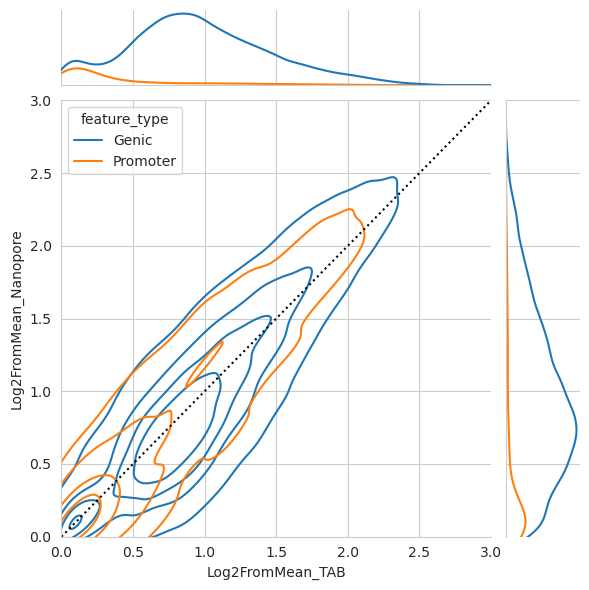

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")

# sns.histplot(tiled_features_df, x="Log2FromMean_TAB", y="Log2FromMean_Nanopore")
jp = sns.jointplot(tiled_features_df.sort_values("CpG_count").replace(["Intron", "Exon", "3UTR", "5UTR"], ["Genic", "Genic", "Genic", "Genic"]).query("feature_type == 'Genic' & CpG_count > 10 | feature_type == 'Promoter' & CpG_count > 10"), 
                x="Log2FromMean_TAB", y="Log2FromMean_Nanopore", 
                hue="feature_type", xlim=(0, 3), ylim=(0, 3), 
                kind="kde", common_norm=False, levels=5)
plt.plot(np.arange(0, 4, 1), np.arange(0, 4, 1), color="black", linestyle=":")


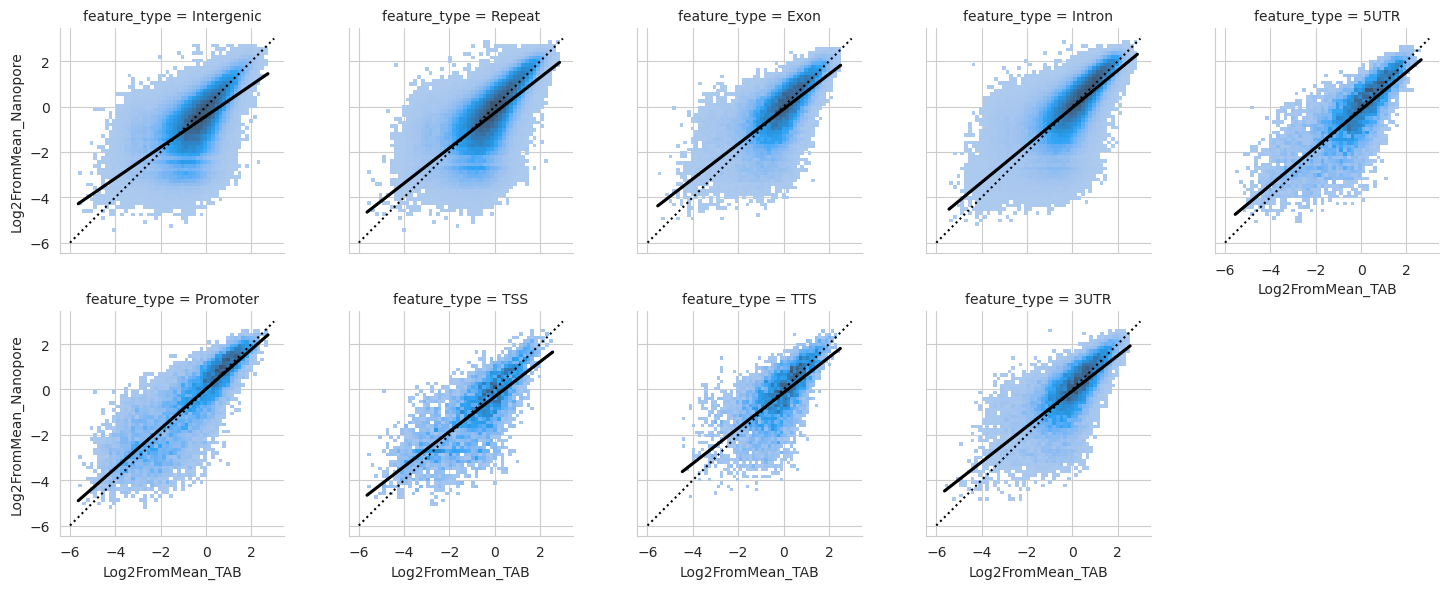

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set_style("whitegrid")

fg = sns.FacetGrid(tiled_features_df.query("CpG_count > 4"), col="feature_type", col_wrap=5, legend_out=False)
fg.map_dataframe(sns.histplot, x="Log2FromMean_TAB", y="Log2FromMean_Nanopore", bins=50)
fg.map_dataframe(sns.regplot, x="Log2FromMean_TAB", y="Log2FromMean_Nanopore", scatter=False, ci=50, color="black")
for ax in fg.axes:
    ax.plot(np.arange(-6, 4, 1), np.arange(-6, 4, 1), color="black", linestyle=":")
    ax.set_aspect("equal")

fg.savefig("/u/n/doh28/Documents/Nanopore_HMC/Test_Figures/Feature_RegHistplots.png", dpi=600)

Comparison with hMeDIP peaks

In [4]:
import pandas as pd
from common import changeColNamesForPR
import pyranges as pr

peaks_from_ip = pd.read_csv("../../data/cbm1_ip_13_07_23/quality_peaks.bedgraph", sep="\t", names=["chromosome", "start", "end", "depth"]).query("depth > 6 & depth < 10")

merged_tiles_with_peaks = pr.PyRanges(feature_tile_df).join(
    pr.PyRanges(peaks_from_ip.rename(columns={
        "chromosome":"Chromosome",
        "start":"Start",
        "end":"End"})
    ), report_overlap=True, suffix="_peak").as_df()

In [15]:
peaks_from_ip.sort_values("depth", ascending=False)

,chromosome,start,end,depth
204558,chr2,68295991,68296816,9
225803,chr3,27744102,27744803,9
358617,chr9,3000003,3001928,9
315655,chr6,140467624,140468789,9
51153,chr11,18825974,18826835,9
...,...,...,...,...
162345,chr17,50310403,50311516,7
163244,chr17,56731780,56732503,7
164134,chr17,64022246,64022934,7
164382,chr17,65199251,65199945,7


In [9]:
ind_tiles_with_peaks = merged_tiles_with_peaks.sort_values("Overlap", ascending=False).groupby(["Chromosome", "Start_peak", "End_peak"])

AttributeError: 'DataFrameGroupBy' object has no attribute 'query'

In [85]:
len(ind_tiles_with_peaks.query("log2enrichment_5hmC_Bisulphite > 0 & log2enrichment_5hmC_Bisulphite > 0"))/len(ind_tiles_with_peaks)

0.7337662337662337

In [87]:
ind_tiles_with_peaks.loc[ind_tiles_with_peaks.loc[:, "log2enrichment_5hmC_Bisulphite"] != -np.inf, "log2enrichment_5hmC_Bisulphite"].mean()

1.2822800935843084

In [8]:
ind_tiles_with_peaks

,Chromosome,Start,End,percentMeth_5mC_Nanopore,percentMeth_5mC_Bisulphite,percentMeth_5hmC_Nanopore,percentMeth_5hmC_Bisulphite,CpG_count,Start_b,End_b,...,Strand,feature_type,log2enrichment_5mC_Min,log2enrichment_5mC_Bisulphite,log2enrichment_5hmC_Min,log2enrichment_5hmC_Bisulphite,Start_peak,End_peak,depth,Overlap
141,chr8,126795300,126795600,58.333333,9.090909,8.333333,7.142857,1,126787263,126865733,...,nan,Intergenic,-0.385313,-3.064798,-0.013799,-0.383362,126794939,126796019,7,300
248,chr16,32878800,32879100,71.428571,58.333333,17.857143,25.000000,2,32876560,32928824,...,-,Intron,-0.093133,-0.382974,1.085737,1.423993,32878726,32879512,7,300
121,chr8,22965600,22965900,30.769231,18.181818,38.461538,58.333333,1,22965800,22968401,...,+,Promoter,-1.308146,-2.064798,2.192652,2.646385,22965275,22966227,8,300
146,chr9,41949000,41949300,42.777778,57.878788,36.666667,35.833333,3,41948517,41952288,...,-,Intron,-0.832772,-0.394260,2.123705,1.943367,41948950,41949486,7,300
151,chr9,56277900,56278200,48.901099,37.222222,34.432234,41.014867,3,56226104,56281659,...,-,Intron,-0.639767,-1.031131,2.032996,2.138212,56277642,56278678,8,300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24,chr2,98496300,98496600,87.500000,100.000000,6.250000,0.000000,1,98496549,98496870,...,nan,Repeat,0.199649,0.394633,-0.428836,-inf,98496579,98496870,7,21
219,chr12,113150700,113151000,0.000000,0.000000,0.000000,7.142857,1,113149578,113151598,...,+,Intron,-inf,-inf,-inf,-0.383362,113150980,113152224,7,20
156,chr9,82839600,82839900,87.500000,69.230769,12.500000,0.000000,1,82827971,82841564,...,-,Intron,0.199649,-0.135881,0.571164,-inf,82839043,82839613,8,13
270,chr18,55099800,55100100,50.000000,70.000000,50.000000,50.000000,1,55079880,55120682,...,-,Intron,-0.607706,-0.119940,2.571164,2.423993,55099144,55099810,7,10


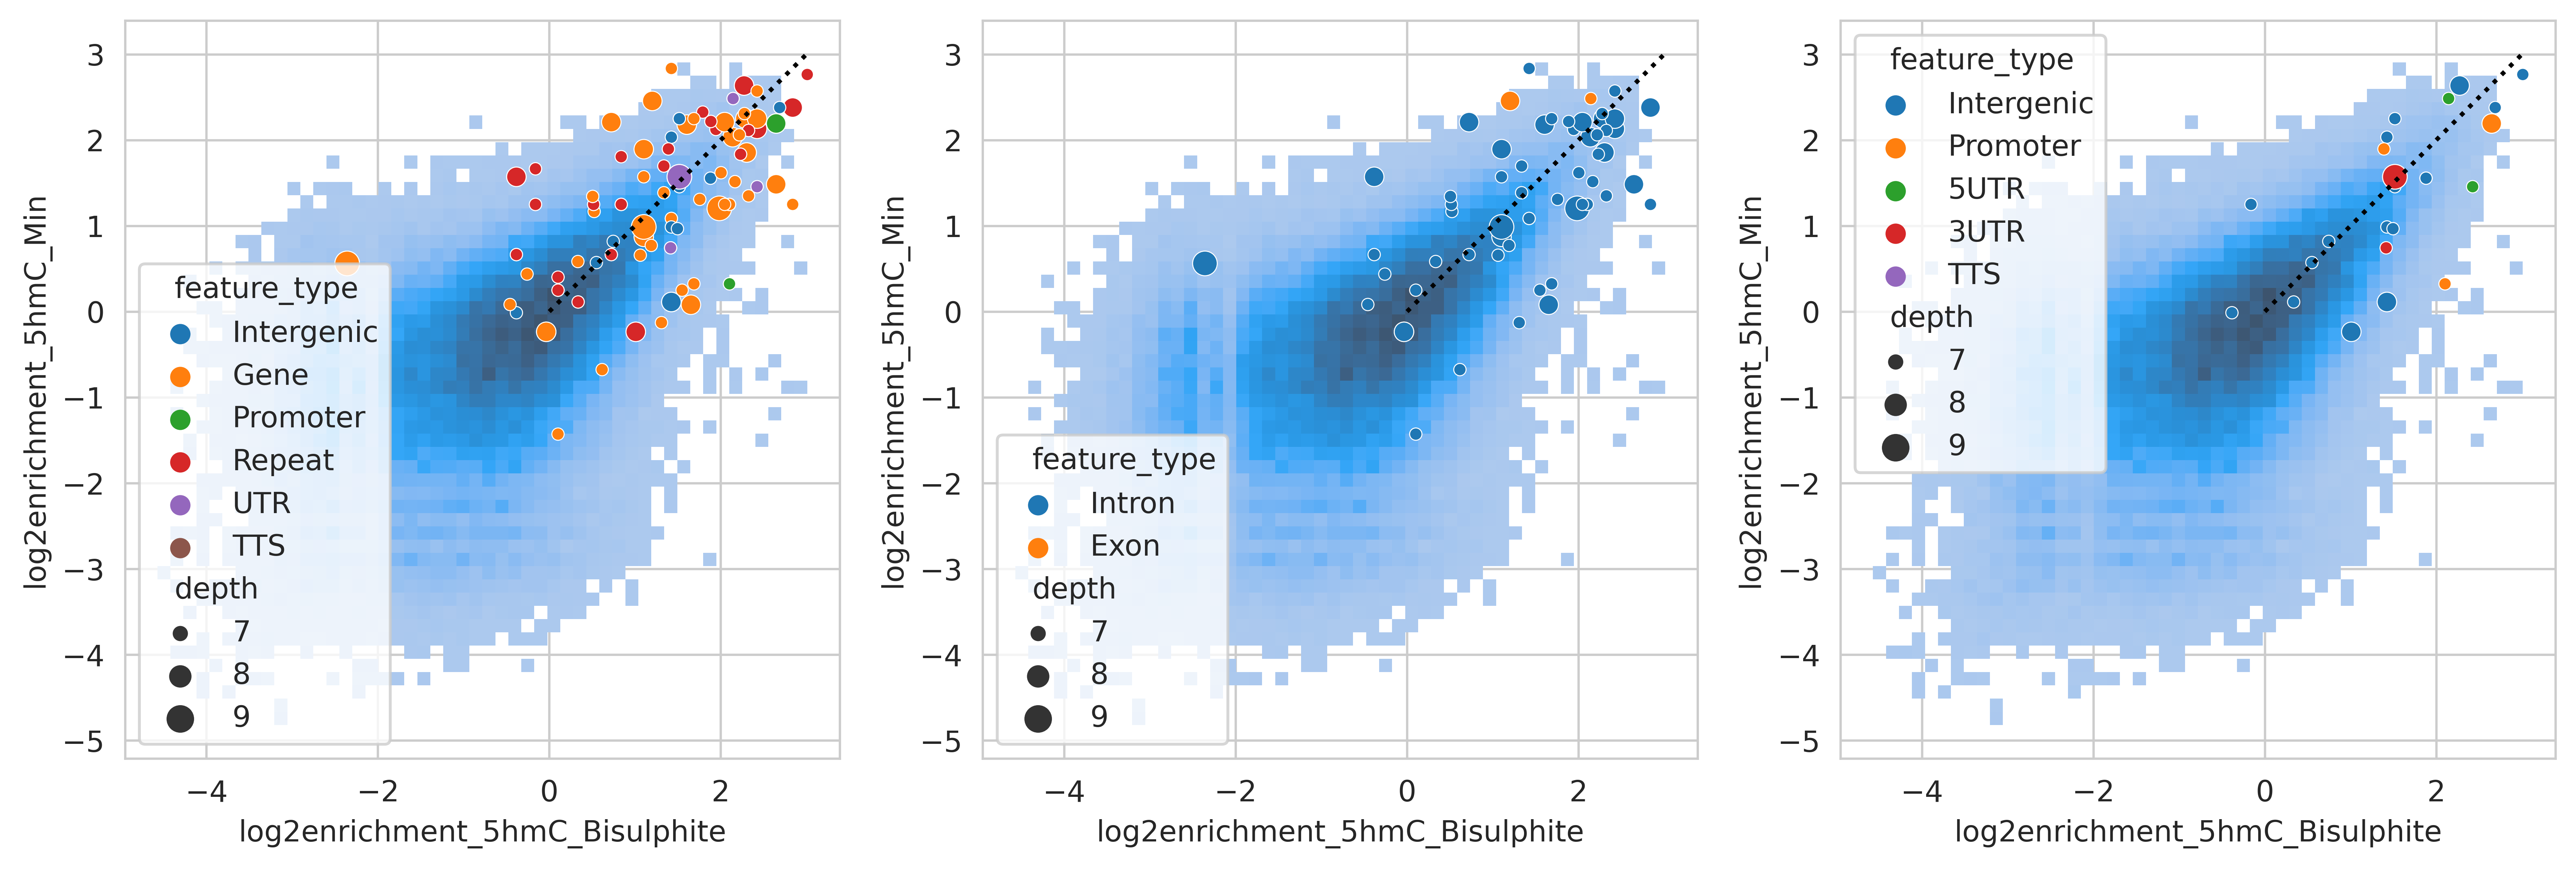

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

fig, axes = plt.subplots(1, 3, figsize=(15, 5), dpi=600)

sns.histplot(feature_tile_df.replace().query("CpG_count > 4"), 
             x="log2enrichment_5hmC_Bisulphite", y="log2enrichment_5hmC_Min", bins=50, ax=axes[0])
sns.scatterplot(ind_tiles_with_peaks.replace(["Intron", "Exon", "3UTR", "5UTR"], ["Gene", "Gene", "UTR", "UTR"]), 
                x="log2enrichment_5hmC_Bisulphite", y="log2enrichment_5hmC_Min", size="depth", hue="feature_type", ax=axes[0])

sns.histplot(feature_tile_df.query("CpG_count > 4"), 
             x="log2enrichment_5hmC_Bisulphite", y="log2enrichment_5hmC_Min", bins=50, ax=axes[1])
sns.scatterplot(ind_tiles_with_peaks.query("feature_type == 'Intron' | feature_type == 'Exon'"), 
             x="log2enrichment_5hmC_Bisulphite", y="log2enrichment_5hmC_Min", size="depth", hue="feature_type", ax=axes[1])

sns.histplot(feature_tile_df.query("CpG_count > 4"), 
             x="log2enrichment_5hmC_Bisulphite", y="log2enrichment_5hmC_Min", bins=50, ax=axes[2])
sns.scatterplot(ind_tiles_with_peaks.query("feature_type != 'Intron' & feature_type != 'Exon' & feature_type != 'Repeat'"), 
             x="log2enrichment_5hmC_Bisulphite", y="log2enrichment_5hmC_Min", size="depth", hue="feature_type", ax=axes[2])

for ax in axes:
    ax.set_aspect("equal")
    ax.plot(np.arange(0, 4, 1), np.arange(0, 4, 1), c="black", ls=":")

In [ ]:
merged_tiles_with_peaks["feature_type"].value_counts()

Intron        422
Repeat        321
Intergenic    105
Exon           67
Promoter       65
3UTR           21
5UTR           21
TTS             5
TSS             4
Name: feature_type, dtype: int64

In [ ]:
ind_tiles_with_peaks["feature_type"].value_counts()

Intron        104
Repeat         45
Intergenic     30
Exon            9
Promoter        6
5UTR            6
3UTR            5
TTS             2
Name: feature_type, dtype: int64

## Figure 4 Stats

In [ ]:
from common import optimisedResample
from Checkpoints import Checkpoint

hmc_df_wide = Checkpoint(path="./intermediates/hmc_df_wide.tsv").loadCheckpoint()
hmc_resample = optimisedResample(hmc_df_wide, "readCount_TAB_5hmC", "readCount_Nanopore_5hmC")

Most common readcount is 11 with 187247 CpGs.


In [ ]:
from common import changeColNamesForPR
hmc_df_wide_feat = CpGIntersects(changeColNamesForPR(hmc_df_wide)).group("features")
hmc_resample_feat = CpGIntersects(changeColNamesForPR(hmc_resample)).group("features")

In [ ]:
from CpGIntersects import CpGIntersects
from scipy import stats
import pandas as pd

def comparisonStatsFeature(feat_intersect_df, cpg_count_thresh=0):
    features = ["Intergenic", "Repeat", "Promoter", "5UTR", "TSS", "Intron", "Exon", "3UTR", "TTS"]
    all_features = {}

    feat_intersect_df = feat_intersect_df.loc[feat_intersect_df.loc[:, "CpG_count"].ge(cpg_count_thresh)]

    for feature in features:
        feature_df = feat_intersect_df.loc[feat_intersect_df.loc[:, "feature_type"] == feature]
        x, y = feature_df["percentMeth_Nanopore"], feature_df["percentMeth_TAB"]

        pr = stats.pearsonr(x, y).statistic.round(3)
        sp = stats.spearmanr(x, y).statistic.round(3)
        swpx, swpy = round(stats.shapiro(x).pvalue, 3), round(stats.shapiro(y).pvalue, 3)
        mwu = stats.mannwhitneyu(x, y).pvalue.round(3)
        kw = stats.kruskal(x, y).pvalue.round(3)

        feature_entry = {feature : {
                            "Pearson" : pr,
                            "Spearman" : sp,
                            "Mann-Whitney" : mwu,
                            "Kruskal-Wallis" : kw,
                            "Features compared" : int(len(feature_df))
                            }
                        }
        all_features.update(feature_entry)
    
    output = pd.DataFrame().from_dict(all_features)
    return output.replace([0, 0.001], ["<0.001", "<0.001"])

In [ ]:
ew = pd.ExcelWriter("/u/n/doh28/Documents/Nanopore_HMC/Feature_stats.xlsx")

comparisonStatsFeature(hmc_df_wide_feat, 2).to_excel(ew, "Non_resampled")
comparisonStatsFeature(hmc_resample_feat, 2).to_excel(ew, "11X_Resampled")
ew.close()

/mnt/data1/doh28/tools/condas/GeneralAnalysis/lib/python3.9/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


## Figure 4 feature hydroxymethylation

In [ ]:
sns.color_palette("Paired", 2)[0]

(0.6509803921568628, 0.807843137254902, 0.8901960784313725)

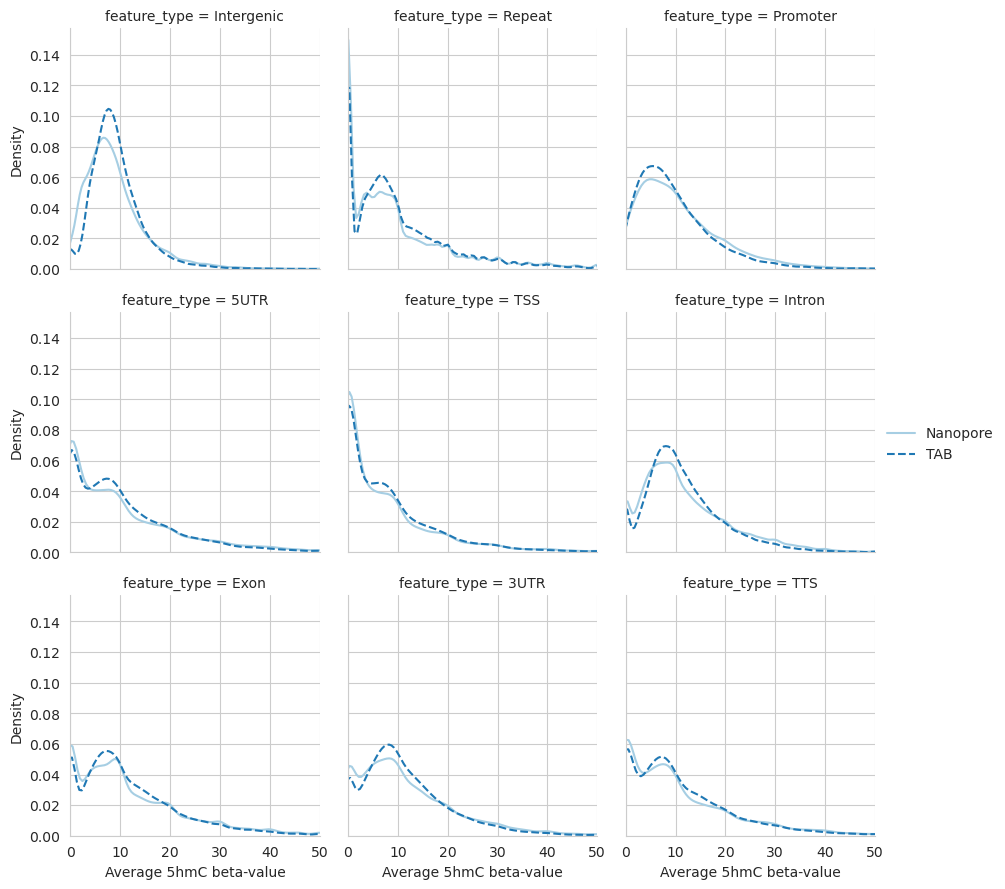

In [ ]:
import seaborn as sns
sns.set_style("whitegrid")

fg = sns.FacetGrid(hmc_df_wide_feat, col="feature_type", xlim=(0, 50), col_wrap=3, legend_out=True)
fg.map_dataframe(sns.kdeplot, x="percentMeth_Nanopore", label="Nanopore", ls="-", color=sns.color_palette("Paired", 2)[0])
fg.map_dataframe(sns.kdeplot, x="percentMeth_TAB", label="TAB", ls="--", color=sns.color_palette("Paired", 2)[1])

fg.set_xlabels("Average 5hmC beta-value")
fg.add_legend()

## Figure 4 repeat hydroxymethylation

In [ ]:
rew = pd.ExcelWriter("./outputs/Repeat_Statistics.xlsx")

In [ ]:
repeat_df = CpGIntersects(eq_depth_test).group("repeats")

NameError: name 'eq_depth_test' is not defined

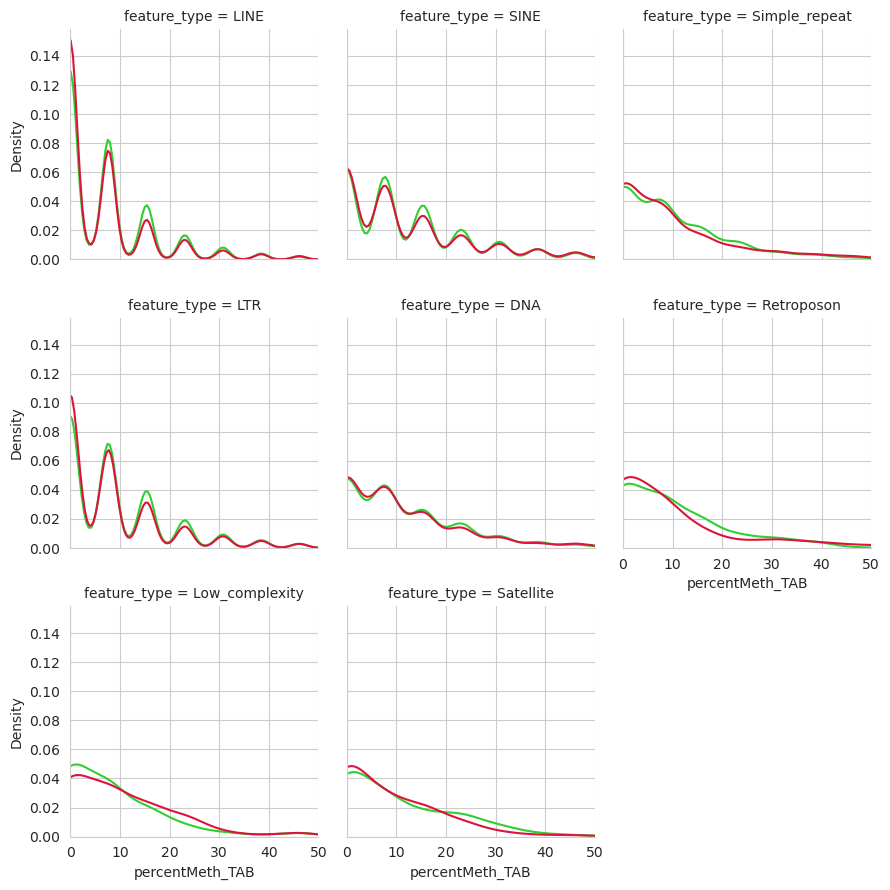

In [ ]:
fg = sns.FacetGrid(repeat_df, col="feature_type", xlim=(0, 50), col_wrap=3)
fg.map_dataframe(sns.kdeplot, x="percentMeth_Nanopore", color="limegreen")
fg.map_dataframe(sns.kdeplot, x="percentMeth_TAB", color="crimson")

In [ ]:
repeats = ["LINE", "SINE", "Simple_repeat", "LTR", "DNA", "Retroposon", "Low_complexity", "Satellite"]

for repeat in repeats:
    df = feature_df.loc[feature_df.loc[:, "feature_type"] == feature]
    sws, swp = stats.shapiro(df["percentMeth_Nanopore"])
    pr = stats.pearsonr(df["percentMeth_Nanopore"], df["percentMeth_TAB"]).statistic.round(3)
    sp = stats.spearmanr(df["percentMeth_Nanopore"], df["percentMeth_TAB"]).statistic.round(3)
    t = stats.ttest_ind(df["percentMeth_Nanopore"], df["percentMeth_TAB"]).pvalue.round(3)
    mwu = stats.mannwhitneyu(x=df["percentMeth_Nanopore"], y=df["percentMeth_TAB"]).pvalue.round(3)
    ks = stats.ks_2samp(df["percentMeth_Nanopore"], df["percentMeth_TAB"]).pvalue
    cvm = stats.cramervonmises_2samp(df["percentMeth_Nanopore"], df["percentMeth_TAB"]).pvalue
    ad = stats.anderson_ksamp([df["percentMeth_Nanopore"], df["percentMeth_TAB"]]).pvalue
    kw = stats.kruskal(df["percentMeth_Nanopore"], df["percentMeth_TAB"]).pvalue
    ab = stats.ansari(df["percentMeth_Nanopore"], df["percentMeth_TAB"]).pvalue.round(3)
    feature_entry = {feature : 
                        {"Shapiro-Wilk stat" : round(sws, 3),
                        "Shapiro-Wilk p-value" : round(swp, 3),
                        "Pearson" : pr.round(3),
                        "Spearman" : sp.round(3),
                        "T-test" : t.round(3),
                        "Mann-Whitney" : mwu.round(3),
                        "Kolmogorov-Smirnov" : ks.round(3), 
                        "Cramer-Von Mises" : cvm.round(3), 
                        "Anderson-Darling" : round(ad, 3), 
                        "Kruskal-Wallis" : kw.round(3),
                        "Sites compared" : len(df)}
                        }
    all_features.update(feature_entry)

# pd.DataFrame().from_dict(all_features).replace(0, "<0.001").to_excel(ew, "NoResample")

NameError: name 'feature_df' is not defined

## Figure 4 CGI hydroxymethylation

In [ ]:
cgi_df = CpGIntersects(eq_depth_test).group("CGI")
# cgi_df = cgi_df.copy().query("CpG_count > 2")

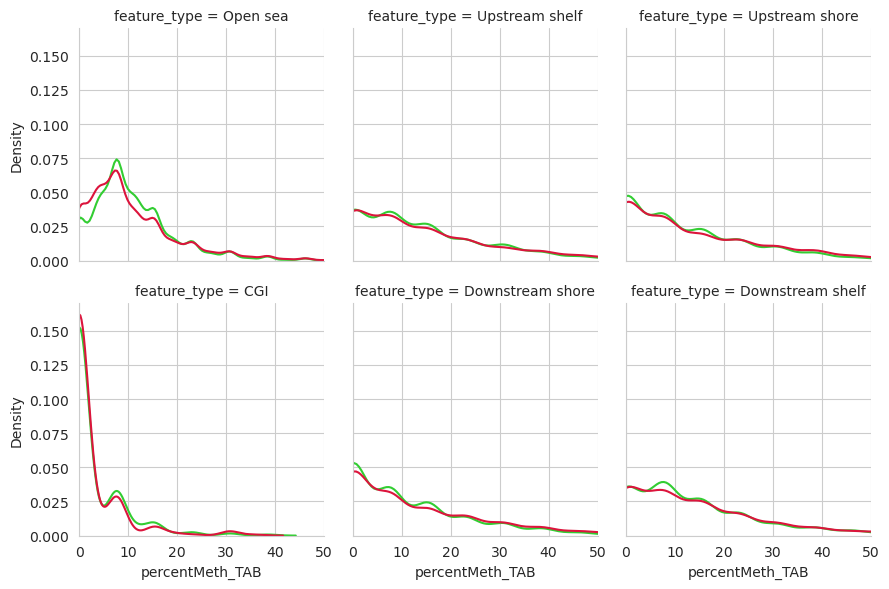

In [ ]:
fg = sns.FacetGrid(cgi_df, col="feature_type", xlim=(0, 50), col_wrap=3)
fg.map_dataframe(sns.kdeplot, x="percentMeth_Nanopore", color="limegreen")
fg.map_dataframe(sns.kdeplot, x="percentMeth_TAB", color="crimson")

In [ ]:
cgis = ["Open sea", "Upstream shelf", "Upstream shore", "CGI", "Downstream shore", "Downstream shelf"]

for cgi in cgis:
    df = cgi_df.loc[cgi_df.loc[:, "feature_type"] == cgi]
    mwu = stats.mannwhitneyu(x=df["percentMeth_Nanopore"], y=df["percentMeth_TAB"]).pvalue
    ks = stats.ks_2samp(df["percentMeth_Nanopore"], df["percentMeth_TAB"]).pvalue
    cvm = stats.cramervonmises_2samp(df["percentMeth_Nanopore"], df["percentMeth_TAB"]).pvalue
    ad = stats.anderson_ksamp([df["percentMeth_Nanopore"], df["percentMeth_TAB"]]).pvalue
    kw = stats.kruskal(df["percentMeth_Nanopore"], df["percentMeth_TAB"]).pvalue
    print(cgi, "MW U: p <", mwu, "KS:", ks, "CVM:", cvm, "AD:", ad, "KW:", kw)

Open sea MW U: p < 6.978955358012615e-19 KS: 1.988504295415333e-133 CVM: 3.2782526693253544e-09 AD: 0.001 KW: 6.978935160834567e-19
Upstream shelf MW U: p < 0.354415143205404 KS: 6.754012325605763e-25 CVM: 4.1102676817672545e-11 AD: 0.001 KW: 0.35439815852707535
Upstream shore MW U: p < 0.0034873489188486833 KS: 1.377865166054312e-29 CVM: 2.745048632846192e-11 AD: 0.001 KW: 0.003487076850285982
CGI MW U: p < 0.5058840283196431 KS: 0.18761407787239476 CVM: 0.5613157617785028 AD: 0.25 KW: 0.5048367415431019
Downstream shore MW U: p < 0.010716301355133925 KS: 1.042856526757089e-26 CVM: 2.7950575187674076e-10 AD: 0.001 KW: 0.01071551584051771
Downstream shelf MW U: p < 0.45645000074048336 KS: 1.6898697592809941e-22 CVM: 5.526723523274768e-11 AD: 0.001 KW: 0.4564317533652299


/tmp/ipykernel_2394402/2350338455.py:8: UserWarning: p-value floored: true value smaller than 0.001
  ad = stats.anderson_ksamp([df["percentMeth_Nanopore"], df["percentMeth_TAB"]]).pvalue
/tmp/ipykernel_2394402/2350338455.py:8: UserWarning: p-value capped: true value larger than 0.25
  ad = stats.anderson_ksamp([df["percentMeth_Nanopore"], df["percentMeth_TAB"]]).pvalue


## Loci for qPCR

In [ ]:
hmc_df_wide = pd.read_csv("./intermediates/hmc_df_wide.tsv", sep="\t", names=["Chromosome", "Start", "End", "strand", "readCount_Nanopore", "percentMeth_Nanopore_5hmC", "readCount_TAB", "percentMeth_Bisulphite_5hmC"]).drop(columns=["readCount_Nanopore", "readCount_TAB"])

In [ ]:
all_tiles = tiledGroup(CpGIntersects(hmc_df_wide).groupByGenomicWindow(200), 2)
all_tiles.exportTests(20)

<Axes: xlabel='Log2FromMean_TAB', ylabel='Log2FromMean_Nanopore'>

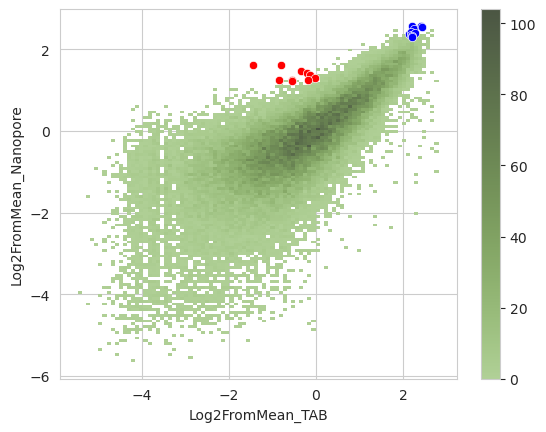

In [ ]:
fig, ax = plt.subplots()
all_tiles.makeHist("count", ax=ax)
sns.scatterplot(all_tiles.NanoporePositiveGroupDF(10).df, x="Log2FromMean_TAB", y="Log2FromMean_Nanopore", c="r")
sns.scatterplot(all_tiles.positiveControlGroupDF(10).df, x="Log2FromMean_TAB", y="Log2FromMean_Nanopore", c="b")